In [1217]:
! pip install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [1218]:
import json
from collections import Counter
import numpy as np
import datetime
import pickle
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from warnings import filterwarnings
import os

filterwarnings("ignore")

In [1219]:

def get_dataloader_forecasting(dataset_name, train_length, skip_length, valid_length=24*5, test_length =24*7, pred_length=24, history_length=168, batch_size=8, device='cuda:0'):
        """
        Prepares DataLoader objects for the forecasting datasets.
        
        Parameters:
        - dataset_name (str): The name of the dataset.
        - train_length, skip_length, valid_length, test_length, pred_length, history_length, batch_size (int): Various parameters defining dataset and DataLoader configurations.
        - device (str): The device to use for loading tensors.
        
        Returns:
        - Tuple[DataLoader, DataLoader, DataLoader, Tensor, Tensor]: Training, validation, and testing DataLoaders, along with scale and mean scale tensors used for normalization.
        """

        train_dataset = MyForecasting_Dataset(dataset_name, train_length, skip_length, valid_length, test_length, pred_length, history_length, is_train=1)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        valid_dataset = MyForecasting_Dataset(dataset_name, train_length, skip_length, valid_length, test_length, pred_length, history_length, is_train=2)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        
        test_dataset = MyForecasting_Dataset(dataset_name, train_length, skip_length, valid_length, test_length, pred_length, history_length, is_train=0)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        predict_dataset = MyForecasting_Dataset(dataset_name, train_length, skip_length, valid_length, test_length, pred_length, history_length, is_train=3)
        predict_loader = DataLoader(predict_dataset, batch_size=batch_size, shuffle=False)


        # scaler = torch.from_numpy(train_dataset.std_data).to(device).float()
        scaler = torch.from_numpy(train_dataset.std_data.astype(np.float32)).to(device)
        mean_scaler = torch.from_numpy(train_dataset.mean_data.astype(np.float32)).to(device)
        all_indices = {
            split: list(train_dataset.main_data_raw.index[idx[0]]) for split, idx in train_dataset.tvt_indices.items()
        }
        df_indices = pd.DataFrame([
            [split, idx[0], idx[1]] for split, indices in all_indices.items()
            for idx in indices
            ], columns=['split', 'country', 'time_period']
        )
        raw_df = train_dataset.main_data_raw
        return train_loader, valid_loader, test_loader, scaler, mean_scaler, df_indices, raw_df, predict_loader


class MyForecasting_Dataset(Dataset):
    def __init__(self, dataset_name, train_length, skip_length, valid_length, test_length, pred_length, history_length, is_train):
        self.train_length = train_length
        self.history_length = history_length
        self.pred_length = pred_length

        self.val_pct = valid_length / 100.
        self.test_pct = test_length / 100.
        self.data_type = dataset_name
        self.seq_length = self.history_length + self.pred_length

        data_path = f'../data/{self.data_type}/{self.data_type}/data.pkl'
        self.main_data_raw = pd.read_pickle(data_path)
        self.mask_data = 1 - self.main_data_raw.isna().astype(int).values
        self.main_data = self.main_data_raw.fillna(0)

        self.tvt_indices = self.get_train_test_from_df()

        if is_train == 0: # test
            self.use_index = self.tvt_indices['test']
            self.mode = 'test'
        elif is_train == 1: # train
            self.use_index = self.tvt_indices['train']
            self.mode = 'train'
        elif is_train == 2: # val
            self.use_index = self.tvt_indices['val']
            self.mode = 'val'
        elif is_train == 3: # predict
            self.use_index = self.tvt_indices['predict']
            self.mode = 'predict'

        # create a set of all indices betweeen start and end for each element of self.tvt_indices
        self.all_train_indices = np.concatenate([np.arange(start, end) for start, end in self.tvt_indices['train']])

        self.mean_data = self.main_data.iloc[self.tvt_indices['train'][:,0]].mean().values
        self.std_data = self.main_data.iloc[self.tvt_indices['train'][:,0]].std().values

        # standardize the data
        self.main_data = ((self.main_data - self.mean_data) / np.maximum(1e-5, self.std_data)).values


        # self.mean_data = self.main_data.iloc[self.tvt_indices['train'][:,0]].mean().values
        # self.std_data = self.main_data.iloc[self.tvt_indices['train'][:,0]].std().values

        # # standardize the data
        # self.main_data = ((self.main_data - self.mean_data) / np.maximum(1e-5, self.std_data)).values

    def get_train_test_from_df(self):

        train_indices = []
        val_indices = []
        test_indices = []
        predict_indices = []

        i = 0

        for geo, chunk in self.main_data.groupby('geo'):
            '''
                generate the train and test indices (aka sequence start index) of a given data frame.
                we group by geo, and within that, split into train and test sections
                according to the provided input_steps, forecast_steps, and val/test_pct
            '''
            chunk_length = len(chunk)

            temp = np.arange(chunk_length)
            n_val_steps = int(chunk_length * self.val_pct)
            n_test_steps = int(chunk_length * self.test_pct) 
            
            # adjust the number of seq_length blocks we need to handle
            if n_val_steps == 0:
                n_seq_length = 1
            else:
                n_seq_length = 2


            # split into "train" and "test/val" sections. anything before the test/val block is considered train
            test_val_len = n_test_steps + n_val_steps + (self.seq_length * n_seq_length)
            train_section = temp[:-test_val_len]
            test_val_section = temp[-test_val_len:]

            # within the test/val block, split into test and val sections according to test length (val length may be zero)
            test_len = n_test_steps + self.seq_length
            val_section = test_val_section[:-test_len]
            test_section = test_val_section[-test_len:]

            # add the start and end indices of each sequence to the respective lists
            train_indices.extend([[i + idx, (i + idx + self.seq_length)] for idx in train_section[:-self.seq_length]])
            val_indices.extend([[i + idx, (i + idx + self.seq_length)] for idx in val_section[:-self.seq_length]])
            test_indices.extend([[i + idx, (i + idx + self.seq_length)] for idx in test_section[:-self.seq_length]])

            # for prediction, we go right up to the end of the sequence, and use min to avoid going over into the next chunk
            predict_indices.extend([[i + idx, (i + min(chunk_length, idx + self.seq_length))] for idx in test_section[:-self.history_length]])
            
            # increment the index by the length of the chunk
            i += chunk_length

        return {
            'train': np.array(train_indices), 
            'val': np.array(val_indices), 
            'test': np.array(test_indices),
            'predict': np.array(predict_indices)
        }
    
    def pad_sample(self, sample):
        """
        Pads a given matrix of shape (n, m) to shape (self.seq_length, m) if n < self.seq_length.
        
        Parameters:
        - sample (np.array): The sample matrix to be padded.
        
        Returns:
        - np.array: The padded matrix.
        """
        if sample.shape[0] < self.seq_length:
            pad = np.zeros((self.seq_length - sample.shape[0], sample.shape[1]))
            sample = np.concatenate([sample, pad], axis=0)
        return sample

    def __getitem__(self, orgindex):
        """
        Gets the MTS at the specified index and pads it if necessary.
        
        Parameters:
        - orgindex (int): The index of the MTS (index of the start timestamp of the sequence).
        
        Returns:
        - dict: A dictionary containing 'observed_data', 'observed_mask', 'gt_mask', 'timepoints', and 'feature_id'.
        """
        [start, end] = self.use_index[orgindex]
        
        # Ensure that the sequences are padded to seq_length if necessary
        observed_data = self.main_data[start:end]
        observed_mask = self.mask_data[start:end]
        
        # Create the target mask and set the last pred_length time steps to 0 (ground truth mask)
        target_mask = self.mask_data[start:end].copy()
        target_mask[-self.pred_length:] = 0.
        
        # Pad the data, mask, and ground truth mask if the sequence is shorter than seq_length
        if (end - start) < self.seq_length:
            observed_data = self.pad_sample(observed_data)
            observed_mask = self.pad_sample(observed_mask)
            target_mask = self.pad_sample(target_mask)
        
        # Create the sample dictionary
        s = {
            'observed_data': observed_data,
            'observed_mask': observed_mask,
            'gt_mask': target_mask,
            'timepoints': np.arange(self.seq_length) * 1.0,  # Assuming timepoints are evenly spaced
            'feature_id': np.arange(self.main_data.shape[1]) * 1.0,  # Feature IDs are the columns
        }
        
        return s
        
    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        
        Returns:
        - int: The total number of samples.
        """
        return len(self.use_index)       


In [1220]:
yo = get_dataloader_forecasting(
        dataset_name='euro_all_countries',
        train_length=-1, # not using
        skip_length=-1, # not using
        valid_length=10, # hack, we're dividing this by 100 to get a percentage
        test_length=10, # hack, we're dividing this by 100 to get a percentage
        pred_length=3,
        history_length=36,
        batch_size=8,
        device= 'cpu',
)        
yo =  yo[-1].dataset
len(yo)


888

In [1221]:
yo.tvt_indices['predict'][:50]

array([[237, 276],
       [238, 277],
       [239, 278],
       [240, 279],
       [241, 280],
       [242, 281],
       [243, 282],
       [244, 283],
       [245, 284],
       [246, 285],
       [247, 286],
       [248, 287],
       [249, 288],
       [250, 289],
       [251, 290],
       [252, 291],
       [253, 292],
       [254, 293],
       [255, 294],
       [256, 295],
       [257, 296],
       [258, 297],
       [259, 298],
       [260, 299],
       [261, 300],
       [262, 301],
       [263, 302],
       [264, 303],
       [265, 304],
       [266, 305],
       [267, 306],
       [268, 306],
       [269, 306],
       [543, 582],
       [544, 583],
       [545, 584],
       [546, 585],
       [547, 586],
       [548, 587],
       [549, 588],
       [550, 589],
       [551, 590],
       [552, 591],
       [553, 592],
       [554, 593],
       [555, 594],
       [556, 595],
       [557, 596],
       [558, 597],
       [559, 598]])

In [1222]:
Counter(yo.tvt_indices['predict'][:,1] - yo.tvt_indices['predict'][:,0])

Counter({39: 834, 38: 27, 37: 27})

In [1223]:
Counter(yo[i]['observed_data'].shape for i in range(len(yo)))

Counter({(39, 19): 888})

In [1224]:
raw = yo.main_data_raw
curr = raw.iloc[yo.tvt_indices['train'][:,0]]
# curr.mean(),
curr.std()

ET-T_EXT_EU27_2020_IMP        5241.390233
ET-T_EXT_EU27_2020_EXP        5874.759616
ET-T_EU27_2020_EXP            8098.006974
moy                              3.422810
ET-CONS_EXT_EU27_2020_IMP     1094.667224
ET-CAP_EU27_2020_IMP          1039.396688
ET-CAP_EXT_EU27_2020_EXP      1466.827729
ET-CAP_EXT_EU27_2020_IMP       971.190553
ET-CONS_EU27_2020_EXP         2275.329743
ET-CONS_EU27_2020_IMP         2067.590590
ET-CONS_EXT_EU27_2020_EXP     1579.680337
ET-INTER_EU27_2020_IMP        3929.937166
ET-INTER_EU27_2020_EXP        4221.017956
short_term                       2.579954
ET-INTER_EXT_EU27_2020_EXP    2750.514546
ET-INTER_EXT_EU27_2020_IMP    3164.405621
ET-T_EU27_2020_IMP            7147.938085
BU                              21.167947
ET-CAP_EU27_2020_EXP          1491.949415
dtype: float64

<Axes: >

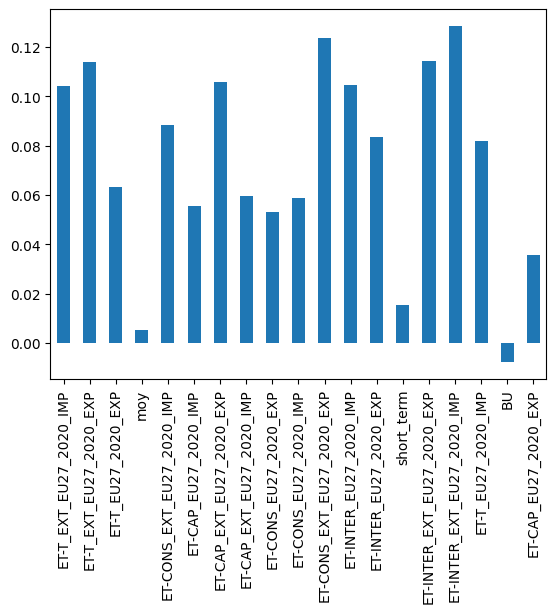

In [1225]:
new = raw.iloc[list(set(yo.all_train_indices))]
# new.mean(), 
((new.std() - curr.std()) / curr.std()).plot(kind='bar')

<Axes: >

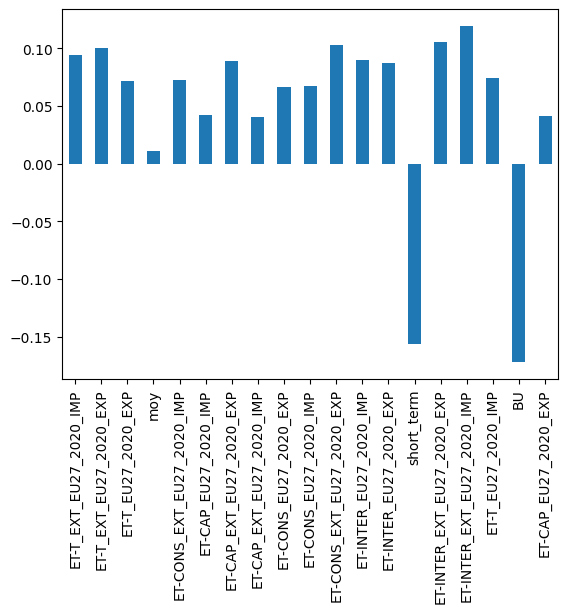

In [1226]:
((new.mean() - curr.mean()) / curr.mean()).plot(kind='bar')

In [1227]:
from collections import Counter

Counter(yo[i]['observed_data'].shape for i in range(len(yo)))
# for i in range(len(yo)):
#     print(yo[i]['observed_data'].shape, yo[i]['observed_mask'].shape, yo[i]['gt_mask'].shape, yo[i]['timepoints'].shape, yo[i]['feature_id'].shape)

Counter({(39, 19): 888})

In [1228]:
yo.use_index[:40]

array([[237, 276],
       [238, 277],
       [239, 278],
       [240, 279],
       [241, 280],
       [242, 281],
       [243, 282],
       [244, 283],
       [245, 284],
       [246, 285],
       [247, 286],
       [248, 287],
       [249, 288],
       [250, 289],
       [251, 290],
       [252, 291],
       [253, 292],
       [254, 293],
       [255, 294],
       [256, 295],
       [257, 296],
       [258, 297],
       [259, 298],
       [260, 299],
       [261, 300],
       [262, 301],
       [263, 302],
       [264, 303],
       [265, 304],
       [266, 305],
       [267, 306],
       [268, 306],
       [269, 306],
       [543, 582],
       [544, 583],
       [545, 584],
       [546, 585],
       [547, 586],
       [548, 587],
       [549, 588]])

In [1229]:
yo.main_data_raw.iloc[269:269+39]

ET-T_EXT_EU27_2020_IMP  ET-T_EXT_EU27_2020_EXP  \
geo time_period                                                   
AT  2021-06-01                   3999.6                  4354.1   
    2021-07-01                   3486.2                  4597.4   
    2021-08-01                   3426.2                  4179.1   
    2021-09-01                   3852.5                  4653.7   
    2021-10-01                   3883.2                  4520.6   
    2021-11-01                   4094.1                  5077.6   
    2021-12-01                   4264.5                  4539.5   
    2022-01-01                   4801.1                  4408.7   
    2022-02-01                   3984.4                  4615.9   
    2022-03-01                   4912.6                  5298.5   
    2022-04-01                   4766.6                  4698.1   
    2022-05-01                   4737.4                  5346.7   
    2022-06-01                   4044.9                  5317.2   
    2022-07-01                   3937.1                  5083.1   
    2022-08-01                   4473.1                  4831.3   
    2022-09-01                   4789.2                  5472.3   
    2022-10-01                   5250.0                  5371.9   
    2022-11-01                   5606.0                  5748.7   
    2022-12-01                   4060.5                  4945.5   
    2023-01-01                   5528.1                  4724.7   
    2023-02-01                   4289.6                  4850.2   
    2023-03-01                   4825.4                  6180.8   
    2023-04-01                   4576.4                  5057.7   
    2023-05-01                   4606.7                  5319.2   
    2023-06-01                   4206.9                  5562.9   
    2023-07-01                   4282.0                  5360.7   
    2023-08-01                   3474.0                  5136.6   
    2023-09-01                   4115.6                  5286.6   
    2023-10-01                   4097.1                  5586.8   
    2023-11-01                   4106.0                  5613.9   
    2023-12-01                   2976.1                  4779.3   
    2024-01-01                   3444.5                  5388.2   
    2024-02-01                   3273.4                  5535.3   
    2024-03-01                   3375.1                  5591.0   
    2024-04-01                   3402.5                  5248.4   
    2024-05-01                   3684.3                  5047.6   
    2024-06-01                   3511.5                  5185.6   
BE  1999-01-01                   4032.6                  3395.1   
    1999-02-01                   4159.0                  3774.8   

                 ET-T_EU27_2020_EXP  moy  ET-CONS_EXT_EU27_2020_IMP  \
geo time_period                                                       
AT  2021-06-01              10200.4    6                      618.1   
    2021-07-01               9978.0    7                      556.8   
    2021-08-01               8665.6    8                      534.4   
    2021-09-01              10671.1    9                      587.1   
    2021-10-01              10229.7   10                      551.4   
    2021-11-01              11327.9   11                      647.4   
    2021-12-01               9779.9   12                      570.9   
    2022-01-01              10516.1    1                      589.3   
    2022-02-01              10981.8    2                      552.9   
    2022-03-01              13046.5    3                      657.4   
    2022-04-01              11355.0    4                      592.0   
    2022-05-01              12234.7    5                      595.3   
    2022-06-01              12009.8    6                      640.1   
    2022-07-01              11164.2    7                      648.9   
    2022-08-01              10523.8    8                      738.2   
    2022-09-01              12822.2    9                      

In [1230]:
yo[269]['observed_data'].round(2)

array([[-0.24, -0.34, -0.47, -0.7 , -0.34, -0.5 , -0.47, -0.42, -0.44,
        -0.24, -0.35, -0.44, -0.48, -1.67, -0.25, -0.14, -0.39,  0.89,
        -0.5 ],
       [-0.16, -0.33, -0.47, -0.41, -0.28, -0.46, -0.47, -0.42, -0.42,
        -0.19, -0.36, -0.43, -0.47, -1.69, -0.22, -0.06, -0.37,  1.12,
        -0.52],
       [-0.27, -0.37, -0.48, -0.12, -0.32, -0.48, -0.47, -0.43, -0.42,
        -0.27, -0.35, -0.45, -0.48, -1.69, -0.32, -0.19, -0.4 ,  1.78,
        -0.52],
       [-0.17, -0.32, -0.46,  0.18, -0.26, -0.48, -0.47, -0.4 , -0.35,
        -0.19, -0.32, -0.44, -0.5 , -1.69, -0.22, -0.06, -0.38,  1.69,
        -0.5 ],
       [-0.23, -0.38, -0.51,  0.47, -0.31, -0.58, -0.48, -0.29, -0.46,
        -0.3 , -0.38, -0.52, -0.53, -1.69, -0.32, -0.16, -0.47,  1.4 ,
        -0.52],
       [-0.24, -0.35, -0.48,  0.76, -0.29, -0.51, -0.47, -0.46, -0.4 ,
        -0.23, -0.37, -0.4 , -0.51, -1.68, -0.26, -0.13, -0.37,  1.53,
        -0.51],
       [-0.22, -0.36, -0.47,  1.05, -0.29, -0.47, -0

In [1231]:
yo.main_data[269:269+39].round(2)

array([[ 0.1 ,  0.16,  0.59, -0.12, -0.1 ,  1.05,  0.2 ,  0.12,  0.37,
         0.96,  0.  ,  1.07,  0.73, -1.74,  0.24,  0.18,  1.  , -0.34,
         0.63],
       [ 0.  ,  0.2 ,  0.57,  0.18, -0.16,  0.85,  0.19,  0.12,  0.31,
         0.85,  0.12,  1.04,  0.71, -1.74,  0.27,  0.04,  0.93, -1.4 ,
         0.62],
       [-0.01,  0.13,  0.4 ,  0.47, -0.18,  0.62,  0.2 ,  0.19,  0.2 ,
         0.77, -0.05,  0.89,  0.54, -1.75,  0.21,  0.01,  0.79, -1.75,
         0.41],
       [ 0.07,  0.21,  0.65,  0.76, -0.13,  1.  ,  0.22,  0.31,  0.37,
         1.  ,  0.09,  1.11,  0.77, -1.76,  0.29,  0.08,  1.03, -2.37,
         0.81],
       [ 0.08,  0.19,  0.6 ,  1.05, -0.17,  0.98,  0.23,  0.22,  0.35,
         0.99,  0.07,  1.1 ,  0.75, -1.75,  0.24,  0.14,  1.02, -1.63,
         0.62],
       [ 0.12,  0.29,  0.73,  1.34, -0.08,  1.12,  0.34,  0.35,  0.4 ,
         1.13,  0.16,  1.23,  0.89, -1.74,  0.32,  0.13,  1.15, -1.31,
         0.87],
       [ 0.15,  0.19,  0.54,  1.64, -0.15,  0.99,  0

In [1232]:
yo.main_data.shape

(8232, 19)

In [1233]:
pd.DataFrame([
    [split, idx[0], idx[1]] for split, indices in yo[-1].items()
    for idx in indices
    ], columns=['split', 'country', 'time_period'])

IndexError: invalid index to scalar variable.

# next steps/to do:
1. `[ ]` functionify the heavy outputs-to-preds df pipeline, run as final part of training pipeline
    - country level RMSE agg of last 6 mo, is there some kind of top picking criteria after that?
1. `[ ]` clean up input data flow, change run args so you can specify 
1. `[ ]` fix dims/num time_stamps in run commands/configs to auto-detect based on input df
1. `[ ]` experiment with forecasting step + 1 instead, can you improve with sequential inputs instead??
1. `[ ]` if masking all but target stratgety (geta better name) works out, reevaluate the et-contxt feature engineering option
1. `[ ]` in the best runs so far, train/val losses are aligned. this means (i think) you haven't even begun to over fit. can you go deeper?
1. `[ ]` parameterize early stopping
1. `[ ]` figure out relative imports?? (this is to aid notebook-ification for hyperparameter sweeps using moonglow)
1. `[ ]` DO THIS LAST: intead of binary nowcast masks, can we schedule a weight reduction over time? probably do this in the finetuning task?
1. `[x]` rerun everything with log transforms?!
    - yielded "best" performance for 2/3 targets
1. `[x]` observe whether any kind of country-bias exists and can be corrected
    - some early work here looks (visually) promising, simple LR on the "early" diffs to predict final 6 mo
    - remove outliers from early diffs
    - build in error correction pipeline
1. `[x]` try on just the 3 target features
1  `[x]` holistic measuring regime to compare runs in terms of competition metrics
1. `[x]` now that you have raw df, do smarter col selection in your loop
1. `[x]` isolate most recent predictions for each country (instead of for each chunk)
1. `[x]` now that you have raw df, can you arrange outputs and targets into a df more comprehensible slicing?
1. `[x]` fix indexing to be smarter... something something relative to n_time_steps?
1. `[x]` add a month number feature
1. `[x]` check proper eval metric
1. `[x]` mask out the non-target feature of the 4 total features
1. `[x]` experiment with blocking out ALL non target features??
    - early results look promising!
1. `[x]` make dataloader export cols and indices (or just the df and the indices)
1. `[x]` rewrite logging to be easily parsable into plots

In [260]:
def print_comment(idx=None):
    if idx is None:
        for k, v in run_comments.items():
            print(f'{k}: {v}')
    elif isinstance(idx, int):
        print(f'{idx}: {run_comments[idx]}')
    elif isinstance(idx, list):
        for i in idx:
            print(f'{i}: {run_comments[i]}')

run_comments = {
    18: 'base_data, 36 mo, default params',
    19: 'base data, 36 mo, light params',
    20: 'future_data, 36 months, light params ',
    21: 'all_euro, 36 months, light params',
    22: 'all_euro, 36 mo, light params, masked out 4 extra cols',
    23: 'base_data, 36 mo, light params, mask out all except target cols',
    24: 'base_data, 36 mo, default params, mask out all except target cols',
    25: 'future_data, 36 mo, light params, mask out all except target cols',
    26: 'base_data + moy, 36 mo, light params',
    27: 'base_data + moy, 36 mo, light_params maskout all except target cols',
    28: 'base_data + moy, 36 mo, default params',
    29: 'base_data + moy, 36 mo, default maskout all except target cols',
    30: 'base_data, 36 mo, default params, way smaller val set',
    ## 31 through 45 were run with 10 prediction steps instead of three
    31: 'base_data, 36 mo, default params, but with log transforms before',
    32: 'eu_all, 36 mo, default params, LOG TRANSFORMS',
    33: 'base_data + "ET-CONXT", 36 mo, default params, LOG TRANSFORMS',
    34: 'base_data + "ET-CONXT" + new future, 36 mo, default params, LOG TRANSFORMS',
    35: 'base_data + "ET-CONXT" + BU/shorterm, 36 mo, default params, LOG TRANSFORMS',
    36: 'base_data + BU/shorterm, 36 mo, light params, LOG TRANSFORMS',
    37: 'slim data, focus on EXP_EU27_2020_EXP, bu/sort term, light params, LOG TRANSFORMS',
    38: 'slim data, focus on EU27_2020_EXP, bu/sort term, light params, LOG TRANSFORMS',
    39: 'slim data, focus on EXT_EU27_2020_IMP, bu/sort term, light params, LOG TRANSFORMS',
    40: 'slim data, focus on EXT_EU27_2020_IMP, bu/sort term, default params, LOG TRANSFORMS',
    41: 'slim data, focus on EXP_EU27_2020_EXP, bu/sort term, default params, LOG TRANSFORMS',
    42: 'slim data, focus on EU27_2020_EXP, bu/sort term, default params, LOG TRANSFORMS',
    43: 'base_data + BU/shorterm, 36 mo, light params',
    44: 'base_data + BU/shorterm + moy, 36 mo, light params',
    45: 'slim data, focus on EU27_2020_EXP + BU/shorterm + moy, 36 mo, light params',
    ## 31 through 45 were run with 10 prediction steps instead of three
    46: 'slim data, focus on EU27_2020_EXP + BU/shorterm + moy, 36 mo, light params, 3 pred steps',
    47: 'base data, 36 mo, light params, 10 pred steps',
    48: 'base data, 36 mo, light params, 10 pred steps, mask out all except target cols',
    49: 'base data + moy + bu/shorterm, 36 mo, light params, 10 pred steps',
}

In [4]:
def get_loss_df(i):
    with open(f'../save/Forecasting/euro_all_countries/n_samples_100_run_{i}_linear_False_sample_feat_True/losses_2.json', 'r') as f:
        losses = data = [json.loads(line) for line in f]
    df_losses = pd.DataFrame(losses)
    max_pretrain_epoch = df_losses[df_losses['mode']=='pretraining']['epoch'].max()
    # add max_training_epoch to epochs where mode is forecasting
    df_losses['epoch'] = df_losses.apply(lambda row: row['epoch'] + max_pretrain_epoch if row['mode'] != 'pretraining' else row['epoch'], axis=1)

    df_losses = df_losses.set_index(['epoch','split','mode',]).unstack().unstack().cummin()

    return df_losses

In [261]:
# run 18: base_data, 36 mo, default params
get_loss_df(47)#.plot()

loss                                
mode  Forecasting           pretraining          
split       train       val       train       val
epoch                                            
0             NaN       NaN    0.397686  0.344735
1             NaN       NaN    0.289736  0.313186
2             NaN       NaN    0.266236  0.292451
3             NaN       NaN    0.254128  0.255831
4             NaN       NaN    0.228271  0.232855
5             NaN       NaN    0.194705  0.199852
6             NaN       NaN    0.154659  0.172442
7             NaN       NaN    0.137490  0.129887
8             NaN       NaN    0.134611  0.129887
9             NaN       NaN    0.124084  0.129887
10            NaN       NaN    0.124084  0.124190
11            NaN       NaN    0.117268  0.124190
12            NaN       NaN    0.117268  0.124190
13            NaN       NaN    0.117268  0.124190
14            NaN       NaN    0.117268  0.124190
15            NaN       NaN    0.113646  0.099700
16            NaN       NaN    0.107369  0.089239
17            NaN       NaN    0.107369  0.089239
18            NaN       NaN    0.107369  0.089239
19            NaN       NaN    0.107369  0.089239
20            NaN       NaN    0.107369  0.089239
21            NaN       NaN    0.107369  0.089239
22            NaN       NaN    0.107369  0.089239
23            NaN       NaN    0.107369  0.089239
24            NaN       NaN    0.107369  0.089239
25            NaN       NaN    0.107369  0.089239
26       0.131374  0.162788    0.104521  0.089239
27       0.130551  0.159131         NaN       NaN
28       0.130418  0.127471         NaN       NaN
29       0.123194  0.127471         NaN       NaN
30       0.123194  0.127471         NaN       NaN
31       0.123194  0.127471         NaN       NaN
32       0.123194  0.124875         NaN       NaN
33       0.123194  0.124875         NaN       NaN
34       0.123194  0.124875         NaN       NaN
35       0.113308  0.124875         NaN       NaN
36       0.113308  0.112394         NaN       NaN
37       0.113308  0.112394         NaN       NaN
38       0.113308  0.112394         NaN       NaN
39       0.113308  0.112394         NaN       NaN
40       0.113308  0.112394         NaN       NaN
41       0.113308  0.112394         NaN       NaN
42       0.113308  0.104127         NaN       NaN
43       0.112534  0.104127         NaN       NaN
44       0.112534  0.104127         NaN       NaN
45       0.112534  0.104127         NaN       NaN
46       0.112534  0.104127         NaN       NaN
47       0.112534  0.104127         NaN       NaN
48       0.112534  0.104127         NaN       NaN
49       0.112534  0.104127         NaN       NaN
50       0.112534  0.104127         NaN       NaN
51       0.112534  0.104127         NaN       NaN
52       0.112534  0.104127         NaN       NaN

<Axes: xlabel='epoch'>

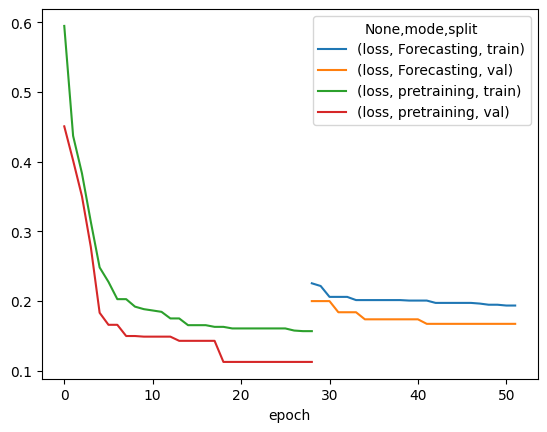

In [52]:
get_loss_df(37).plot()

### old data loading code below

In [235]:
def align_samples(df, target_cols, sample_dict, n_forward_steps):
    delta = pd.Series([pd.DateOffset(months=m+1) for m in range(n_forward_steps)])
    my_cols = [col for col in df.columns if col in TARGET_COLS]

    yo = []

    for k, v in sample_dict.items():
        for i in range(100):
            df_temp = pd.DataFrame(v[i].cpu(), columns=df.columns)[my_cols]
            df_temp['pred_id'] = i
            df_temp['geo'] = k[0]
            df_temp['base_period'] = k[1] + pd.DateOffset(months=36)
            df_temp['time_horizon'] = [m + 1 for m in range(n_forward_steps)]
            df_temp['time_period'] = pd.to_datetime(df_temp['base_period'] + delta)
            yo.append(df_temp)

    return pd.concat(yo)


def make_analytics_df(run_id, input_length, n_forward_steps=3):
    path = f'../save/Forecasting/euro_all_countries/n_samples_100_run_{run_id}_linear_False_sample_feat_True'
    with open(f'{path}/generated_outputs_nsample100.pk', 'rb') as f:
        outputs = pickle.load(f)
        all_generated_samples, all_target, all_evalpoint, all_observed_point, all_observed_time, scaler, mean_scaler = outputs
    
    time_horizon = all_generated_samples.shape[2] - input_length
    if time_horizon not in [3, 10]:
        raise ValueError(f'Unexpected series length: {time_horizon}')
    
    all_generated_samples = all_generated_samples * scaler + mean_scaler
    df = pd.read_pickle(f'{path}/raw_df.pkl')
    df_indices = pd.read_pickle(f'{path}/df_indices.pkl')

    df_indices = df_indices[df_indices['split']=='test']

    df.shape, df_indices.shape, all_generated_samples.shape

    all_samples = [s for s in all_generated_samples]

    sample_dict = {(country, time_period): sample[:, -time_horizon:, :][:, :n_forward_steps, :] for (country, time_period), sample in zip(df_indices[['country', 'time_period']].values, all_samples)}

    return df, sample_dict




TARGET_COLS = ['ET-T_EU27_2020_EXP', 'ET-T_EXT_EU27_2020_EXP', 'ET-T_EXT_EU27_2020_IMP']
input_length = 36
n_forward_steps = 3

path = f'../save/Forecasting/euro_all_countries/'
# check in all folder ins path to see if generated_outputs_nsample100.pk exists


for root, dirs, files in os.walk(path):
    if any([f.startswith('generated_outputs_nsample') for f in files]):
        print(root, 'YES')
    if 'generated_outputs_nsample100.pk' in files:
        run_id = root.replace('../save/Forecasting/euro_all_countries/n_samples_100_run_', '')
        run_id = run_id.split('_')[0]
        if run_id == '47':
            print(root, run_id)
            print('no df_samples.pkl')
            df, sample_dict = make_analytics_df(int(run_id), input_length)
            df_samples = align_samples(df, TARGET_COLS, sample_dict, n_forward_steps)
            df_samples.to_pickle(f'{root}/df_samples.pkl')


# for run_id in range(18, 34):
#     print(run_id)
#     df, sample_dict = make_analytics_df(run_id, input_length)
#     # df_samples = align_samples(df, TARGET_COLS, sample_dict, 3)
#     # df_samples.to_pickle(f'../save/Forecasting/euro_all_countries/n_samples_100_run_{run_id}_linear_False_sample_feat_True/df_samples.pkl')

### new data loading code below

In [296]:
def align_samples(df, target_cols, sample_dict, n_samples, n_forward_steps, input_length):
    # Create the date offsets for forward steps
    delta = np.array([pd.DateOffset(months=m+1) for m in range(n_forward_steps)])
    
    # Filter the columns that match the target columns present in the data
    my_cols = [col for col in target_cols if col in df.columns]
    n_cols = len(my_cols)
    
    # Preallocate lists to collect all the necessary data
    pred_ids = []
    geos = []
    base_periods = []
    time_horizons = []
    time_periods = []
    aligned_samples = []
    
    for (geo, base_period), samples in sample_dict.items():
        # Precompute base period offset and time_periods for this sample
        base_period_offset = base_period + pd.DateOffset(months=input_length)
        time_period = pd.to_datetime(base_period_offset + delta)
        
        # For each sample, align and append data
        for i in range(n_samples):
            sample_np = samples[i].cpu().numpy()  # Convert to NumPy
            
            # Slice to get only relevant columns
            aligned_sample = pd.DataFrame(sample_np, columns=df.columns)[my_cols].values
            
            # Collect the aligned samples
            aligned_samples.append(aligned_sample)
            
            # Add metadata for each row in the sample
            pred_ids.extend([i] * n_forward_steps)  # Each sample has n_forward_steps
            geos.extend([geo] * n_forward_steps)
            base_periods.extend([base_period_offset] * n_forward_steps)
            time_horizons.extend(list(range(1, n_forward_steps + 1)))
            time_periods.extend(time_period)
    
    # Concatenate aligned samples into a single NumPy array
    aligned_samples = np.concatenate(aligned_samples, axis=0)  # Stack vertically
    
    # Create the final DataFrame
    df_samples = pd.DataFrame(aligned_samples, columns=my_cols)
    
    # Add the metadata columns
    df_samples['pred_id'] = pred_ids
    df_samples['geo'] = geos
    df_samples['base_period'] = base_periods
    df_samples['time_horizon'] = time_horizons
    df_samples['time_period'] = time_periods
    
    return df_samples


def make_analytics_df(run_id, input_length, filename, n_forward_steps=3):
    # Load saved results from pickle files
    path = f'../save/Forecasting/euro_all_countries/n_samples_100_run_{run_id}_linear_False_sample_feat_True'
    with open(f'{path}/{filename}', 'rb') as f:
        outputs = pickle.load(f)
        (all_generated_samples, all_target, all_evalpoint, 
         all_observed_point, all_observed_time, scaler, mean_scaler) = outputs

    # Validate the time horizon length
    time_horizon = all_generated_samples.shape[2] - input_length
    if time_horizon not in [3, 10]:
        raise ValueError(f'Unexpected series length: {time_horizon}')
    
    # Scale the samples back to original values
    all_generated_samples = all_generated_samples * scaler + mean_scaler
    
    # Load the original dataframe and indices for alignment
    df = pd.read_pickle(f'{path}/raw_df.pkl')
    df_indices = pd.read_pickle(f'{path}/df_indices.pkl')
    df_indices = df_indices[df_indices['split'] == 'test']
    
    # slice all_generated_samples to get only the relevant  prediction steps
    my_samples = all_generated_samples[:, :, -time_horizon:, :][:, :, :n_forward_steps, :]
    sample_dict = {
        (country, time_period): sample
        for (country, time_period), sample in zip(df_indices[['country', 'time_period']].values, my_samples)
    }    
    return df, sample_dict


def count_subfolders(path):
    # Count the number of subfolders in the given path
    return len([f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))])

def process_subfolders(input_length, n_forward_steps, target_run_id=None):
    path = '../save/Forecasting/euro_all_countries/'
    
    num_subfolders = count_subfolders(path)
    for root, dirs, files in tqdm(os.walk(path), total=num_subfolders):
        sample_files = [f for f in files if f.startswith('generated_outputs_nsample')]
        if len(sample_files) == 0:
            continue

        filename = sample_files[0]
        
        # Extract run_id from folder path
        run_id = root.replace('../save/Forecasting/euro_all_countries/n_samples_100_run_', '').split('_')[0]
        
        # If target_run_id is specified, process only that folder
        if target_run_id and run_id != target_run_id:
            continue
        
        # print(f"Processing folder: {root}, Run ID: {run_id}")
        
        # Call the function to load and process the data
        df, sample_dict = make_analytics_df(int(run_id), input_length, filename, n_forward_steps)
        
        # Get the number of samples dynamically from the sample dict
        first_key = next(iter(sample_dict))
        n_samples = sample_dict[first_key].shape[0]
        
        # Align the samples
        df_samples = align_samples(df, TARGET_COLS, sample_dict, n_samples, n_forward_steps, input_length)
        
        # Save the result to a pickle file
        df_samples.to_pickle(f'{root}/df_samples.pkl')


TARGET_COLS = ['ET-T_EU27_2020_EXP', 'ET-T_EXT_EU27_2020_EXP', 'ET-T_EXT_EU27_2020_IMP']
input_length = 36
n_forward_steps = 3

# bulk update:
# process_subfolders(input_length=input_length, n_forward_steps=n_forward_steps)

# specific run_id:
process_subfolders(input_length=input_length, n_forward_steps=n_forward_steps, target_run_id='49')

33it [00:05,  6.57it/s]                        


In [275]:
# run_id = '48'

# path = f'../save/Forecasting/euro_all_countries/n_samples_100_run_{run_id}_linear_False_sample_feat_True'
# with open(f'{path}/generated_outputs_nsample50.pk', 'rb') as f:
#     outputs = pickle.load(f)
#     (all_generated_samples, all_target, all_evalpoint, 
#         all_observed_point, all_observed_time, scaler, mean_scaler) = outputs
    

# df_indices = pd.read_pickle(f'{path}/df_indices.pkl')
# df_indices = df_indices[df_indices['split'] == 'test']
# print(df_indices.shape)
# print(all_generated_samples.shape)
# # Validate the time horizon length
# time_horizon = all_generated_samples.shape[2] - input_length
# if time_horizon not in [3, 10]:
#     raise ValueError(f'Unexpected series length: {time_horizon}')

# # Scale the samples back to original values
# all_generated_samples = all_generated_samples * scaler + mean_scaler

# time_horizon
# # input_length = 36
# # n_forward_steps = 3
# my_samples = all_generated_samples[:, :, -time_horizon:, :][:, :, :n_forward_steps, :]
# {
#     (country, time_period): sample
#     for (country, time_period), sample in zip(df_indices[['country', 'time_period']].values, my_samples)
# }

In [477]:
def get_dfs(run_id):
    df_samples = pd.read_pickle(f'../save/Forecasting/euro_all_countries/n_samples_100_run_{run_id}_linear_False_sample_feat_True/df_samples.pkl')
    df_target = pd.read_pickle(f'../save/Forecasting/euro_all_countries/n_samples_100_run_{run_id}_linear_False_sample_feat_True/raw_df.pkl')

    return df_samples, df_target

def get_eval_data(df_samples, df_target, time_horizon):
    my_cols = [col for col in df_samples.columns if col in TARGET_COLS]
    yo_temp = df_samples[df_samples['time_horizon'] == time_horizon]
    yo_temp[my_cols] = yo_temp[my_cols].where(yo_temp[my_cols] > 0, 50)

    preds = yo_temp.groupby(['geo', 'time_period'])[my_cols].median()
    preds = preds.where(preds > 0, 0)

    target = df_target[my_cols]
    target = target.loc[preds.index]

    diff = preds - target
    diff_pct = diff / target
    rel_diff = preds / target
    msre_raw = (diff_pct) ** 2

    return {
        'preds': preds,
        'target': target,
        'diff': diff,
        'diff_pct': diff_pct,
        'rel_diff': rel_diff,
        'msre_raw': msre_raw
    } 

def raw_msre_eval(run_id, time_horizon=3, n_months=6):
    eval_data = get_eval_data(run_id, time_horizon)
    msre_raw = eval_data['msre_raw']

    return msre_raw.groupby('geo').tail(n_months).groupby('geo').mean().sum()


to_log = [31,32,33,34,35,36,37,38,39,40,41,42]


raw_msres = {}
for run_id in range(18, 50):
# for run_id in [18,47,48]:
    df_samples, df_target = get_dfs(run_id)
    my_cols = [col for col in df_samples.columns if col in TARGET_COLS]
    # print(my_cols)
    if run_id in to_log:
        # reverse log transform
        df_samples[my_cols] = np.exp(df_samples[my_cols])
        df_target[my_cols] = np.exp(df_target[my_cols])
    eval_data = get_eval_data(df_samples, df_target, 3)

    raw_msres[run_id] = eval_data['msre_raw'].groupby('geo').tail(6).groupby('geo').mean().sum()

df_raw_msres = pd.DataFrame(raw_msres).T
# df_raw_msres.plot.bar(logy=True, figsize=(15,5))

In [377]:
raw_msres[18]

ET-T_EU27_2020_EXP        1.214130
ET-T_EXT_EU27_2020_EXP    1.890259
ET-T_EXT_EU27_2020_IMP    2.673689
dtype: float64

<Axes: title={'center': 'Adjusted MSRE'}>

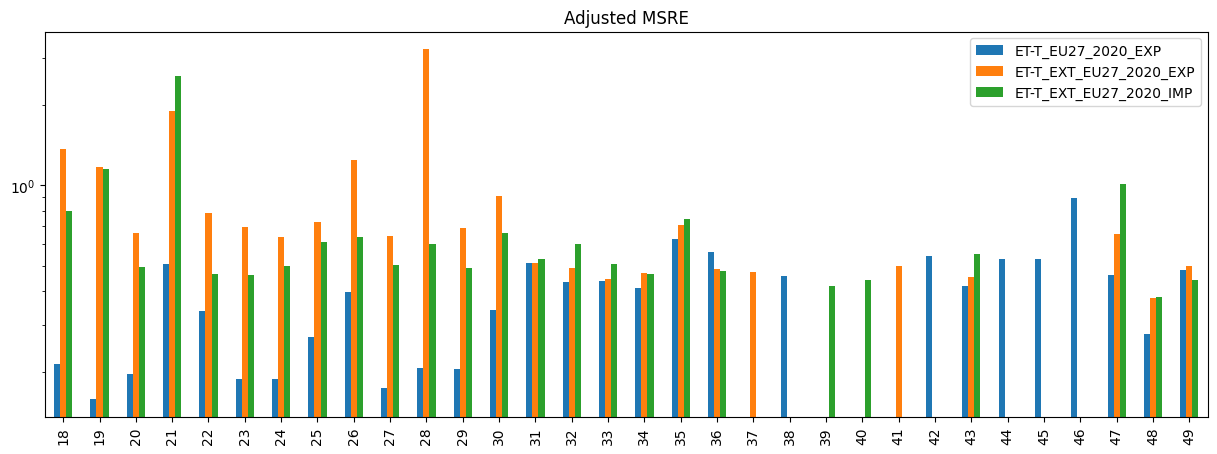

In [303]:
def adj_msre_eval(eval_data, time_horizon=3, n_months=6):
    preds = eval_data['preds']
    rel_diff = eval_data['rel_diff']
    target = eval_data['target']

    ewm_params = {
        'com': [i / 25 for i in range(25, 500, 25)],
        'span': [i / 25 for i in range(25, 500, 25)],
        'halflife': range(1, 100),
        'alpha': [i / 100 for i in range(1, 100, 5)]  # alpha should be between 0 and 1
    }

    yo_dict = {}
    for param_name, param_values in ewm_params.items():
        for param_value in param_values:
            # Create the keyword argument dynamically
            kwargs = {param_name: param_value}

            rel_diff_means = rel_diff.groupby('geo').apply(lambda x: x.ewm(**kwargs).mean().shift(time_horizon)).droplevel(0)
            new_preds = preds.div(rel_diff_means, axis=1)
            new_rmse = (((new_preds - target) / target) ** 2)

            yo_dict[(param_name, param_value)] = new_rmse.groupby('geo').tail(n_months).groupby('geo').mean()

    stacked = np.stack([x.values for x in yo_dict.values()])
    return stacked.min(axis=0).sum(axis=0)


adj_msres = {}

for run_id in range(18, 50):
# for run_id in [18,47,48]:
    df_samples, df_target = get_dfs(run_id)
    my_cols = [col for col in df_samples.columns if col in TARGET_COLS]
    my_cols.sort()
    # print(my_cols)
    if run_id in to_log:
        # reverse log transform
        df_samples[my_cols] = np.exp(df_samples[my_cols])
        df_target[my_cols] = np.exp(df_target[my_cols])
        
    eval_data = get_eval_data(df_samples, df_target, 3)
    
    adj_msres[run_id] = {col: val for col, val in zip (my_cols, adj_msre_eval(eval_data))}

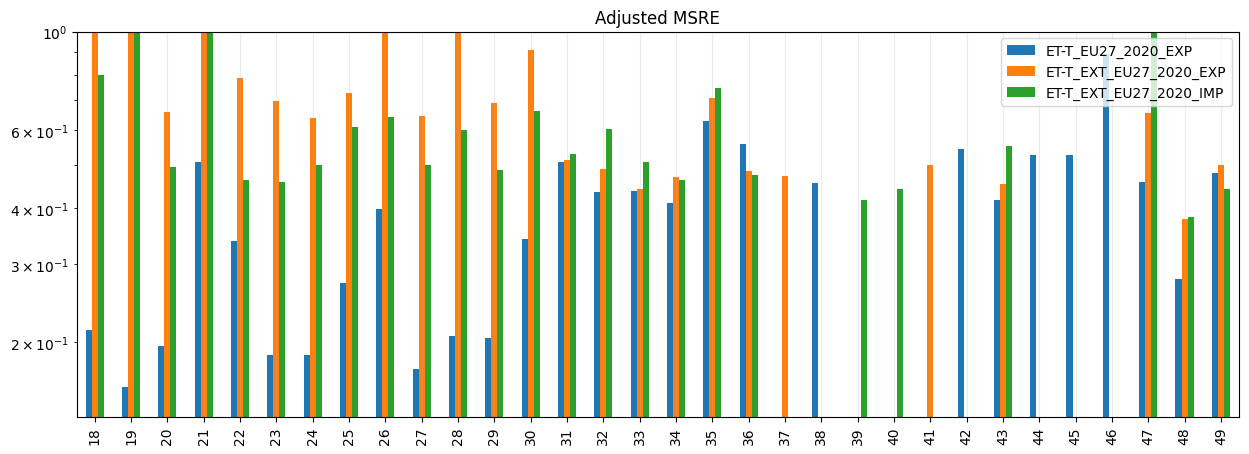

In [331]:
df_adj_msre = pd.DataFrame(adj_msres, index=TARGET_COLS).T
ax = df_adj_msre.plot.bar(figsize=(15,5), logy=True, title='Adjusted MSRE')    
ax.set_ylim(0, 1)
ax.grid(alpha=0.25)

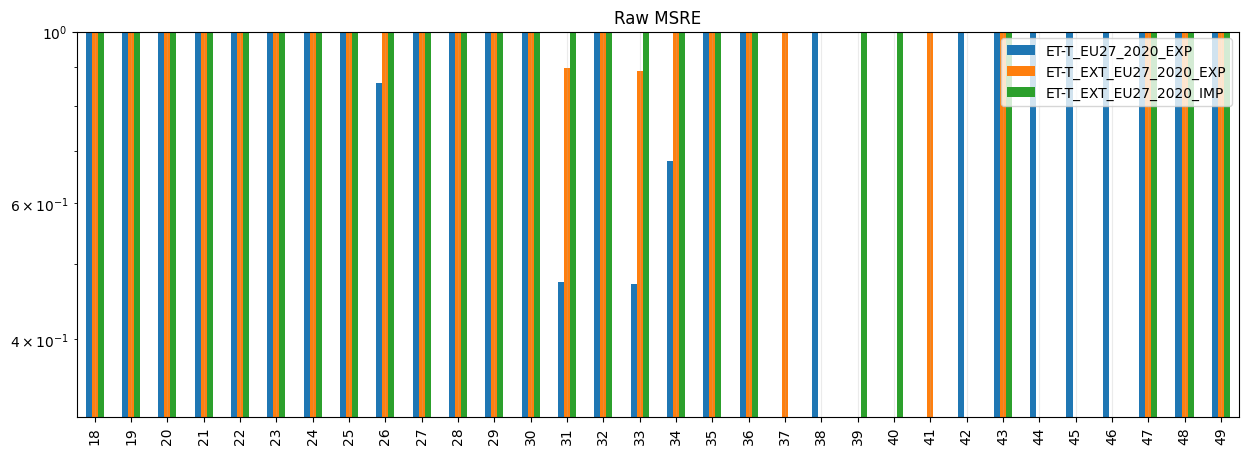

In [332]:
ax = df_raw_msres.plot.bar(logy=True, figsize=(15,5), title='Raw MSRE')
ax.set_ylim(0, 1)
# plt.gca().invert_yaxis()
ax.grid(alpha=0.25)

<Axes: >

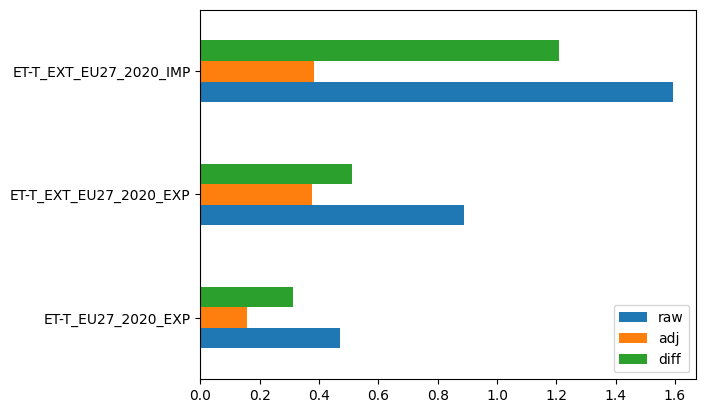

In [300]:
# shows that adjusment improves the MSRE across the board
pd.DataFrame({
    'raw': df_raw_msres.min(),
    'adj': df_adj_msre.min(),
    'diff': df_raw_msres.min() - df_adj_msre.min()
}).plot.barh()

In [1308]:
# print_comment([26, 27, 28, 29, 30, 43, 44, 45])
print_comment()

18: base_data, 36 mo, default params
19: base data, 36 mo, light params
20: future_data, 36 months, light params 
21: all_euro, 36 months, light params
22: all_euro, 36 mo, light params, masked out 4 extra cols
23: base_data, 36 mo, light params, mask out all except target cols
24: base_data, 36 mo, default params, mask out all except target cols
25: future_data, 36 mo, light params, mask out all except target cols
26: base_data + moy, 36 mo, light params
27: base_data + moy, 36 mo, light_params maskout all except target cols
28: base_data + moy, 36 mo, default params
29: base_data + moy, 36 mo, default maskout all except target cols
30: base_data, 36 mo, default params, way smaller val set
31: base_data, 36 mo, default params, but with log transforms before
32: eu_all, 36 mo, default params, LOG TRANSFORMS
33: base_data + "ET-CONXT", 36 mo, default params, LOG TRANSFORMS
34: base_data + "ET-CONXT" + new future, 36 mo, default params, LOG TRANSFORMS
35: base_data + "ET-CONXT" + BU/shor

In [301]:
best_scores = pd.DataFrame(adj_msres, index=TARGET_COLS).T.min()
best_idx = pd.DataFrame(adj_msres, index=TARGET_COLS).T.idxmin()

best_df = pd.DataFrame([best_scores, best_idx], index=['score', 'idx']).T
best_df['country_avg'] = best_df['score'] / 27

best_df

score   idx  country_avg
ET-T_EU27_2020_EXP      0.158362  19.0     0.005865
ET-T_EXT_EU27_2020_EXP  0.378017  48.0     0.014001
ET-T_EXT_EU27_2020_IMP  0.382310  48.0     0.014160

In [325]:
pd.DataFrame(adj_msres, index=TARGET_COLS).T

ET-T_EU27_2020_EXP  ET-T_EXT_EU27_2020_EXP  ET-T_EXT_EU27_2020_IMP
18            0.213411                1.362288                0.797781
19            0.158362                1.165008                1.145786
20            0.195807                0.660551                0.495268
21            0.507604                1.893708                2.568509
22            0.337722                0.787078                0.463418
23            0.187658                0.696696                0.459175
24            0.187459                0.640173                0.499978
25            0.271346                0.728596                0.610443
26            0.399326                1.237214                0.641499
27            0.174347                0.644672                0.501526
28            0.206931                3.227502                0.600897
29            0.204748                0.690288                0.487795
30            0.342115                0.908035                0.662553
31            0.509578                0.512886                0.530645
32            0.435292                0.490514                0.604161
33            0.438406                0.443443                0.508417
34            0.411563                0.470698                0.464101
35            0.630074                0.708601                0.747817
36            0.559515                0.485022                0.476932
37                 NaN                0.474403                     NaN
38            0.455438                     NaN                     NaN
39                 NaN                     NaN                0.417867
40                 NaN                     NaN                0.441436
41                 NaN                0.499757                     NaN
42            0.544782                     NaN                     NaN
43            0.418810                0.453336                0.554138
44            0.527912                     NaN                     NaN
45            0.527912                     NaN                     NaN
46            0.891010                     NaN                     NaN
47            0.459089                0.655482                1.011406
48            0.277771                0.378017                0.382310
49            0.481780                0.500154                0.441411

In [459]:
run_id = 48

# yo, df = get_dfs(run_id)
df_samples, df_target = get_dfs(run_id)
# # reverse log transform
my_cols = [col for col in df_target.columns if col in TARGET_COLS]
# yo[my_cols] = np.exp(yo[my_cols])
# df[my_cols] = np.exp(df[my_cols])

AT


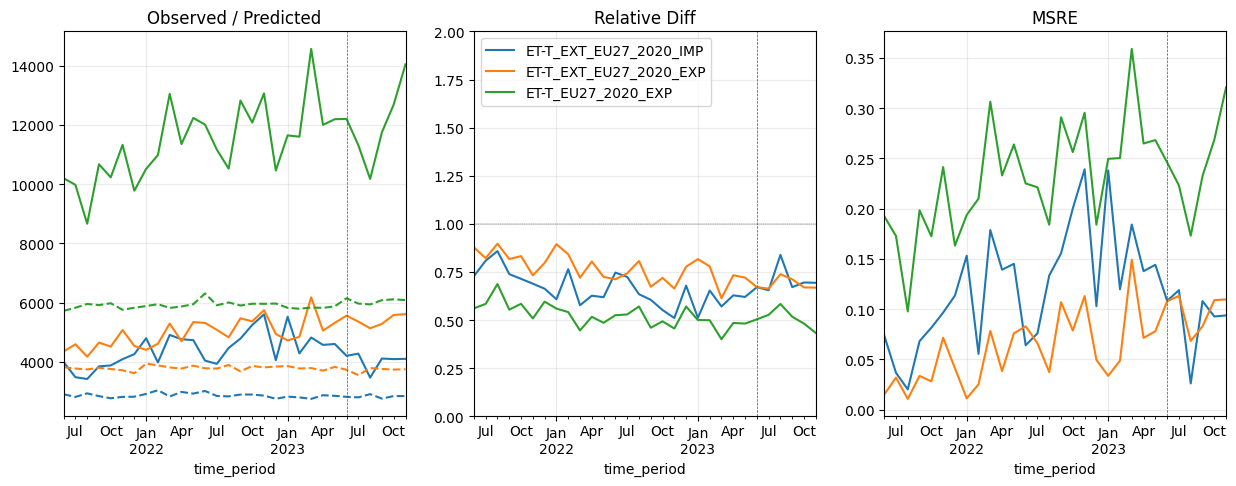

BE


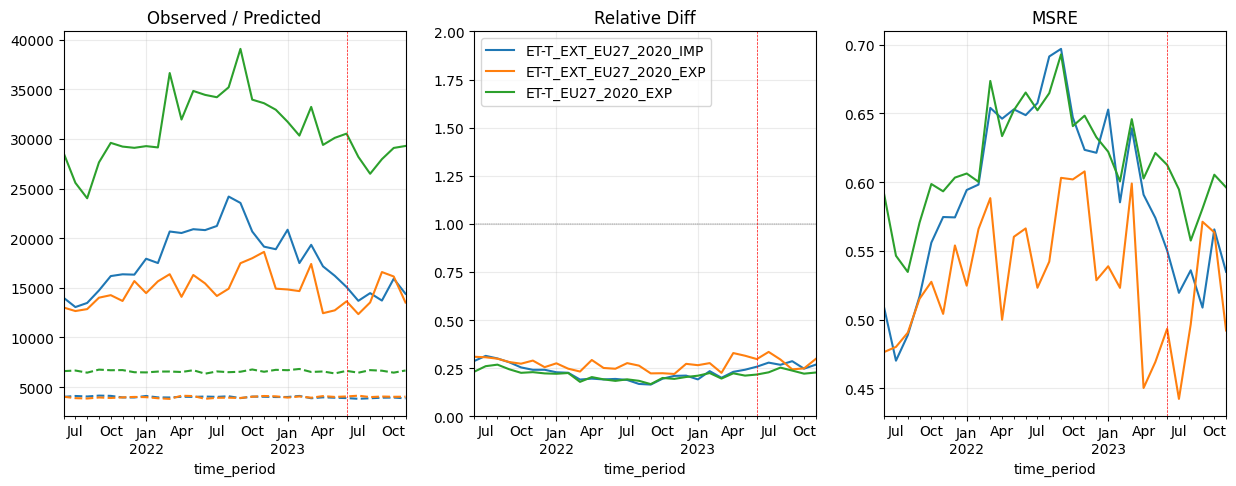

BG


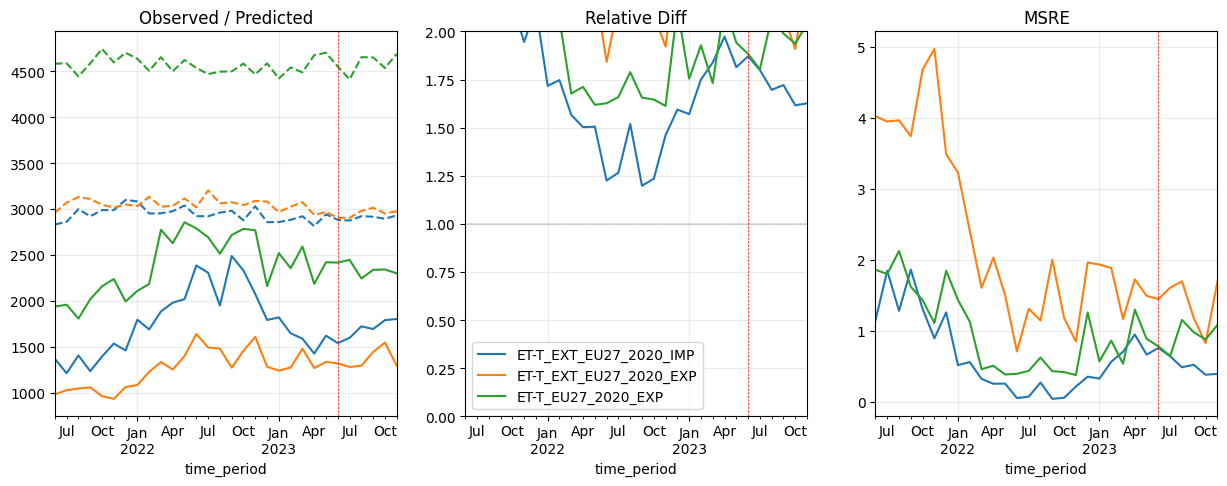

CY


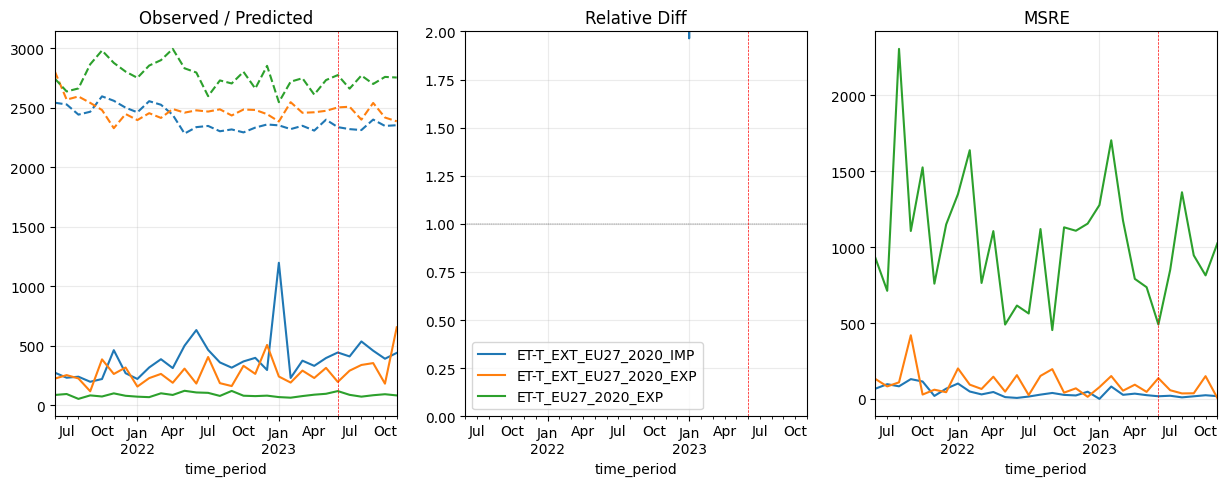

CZ


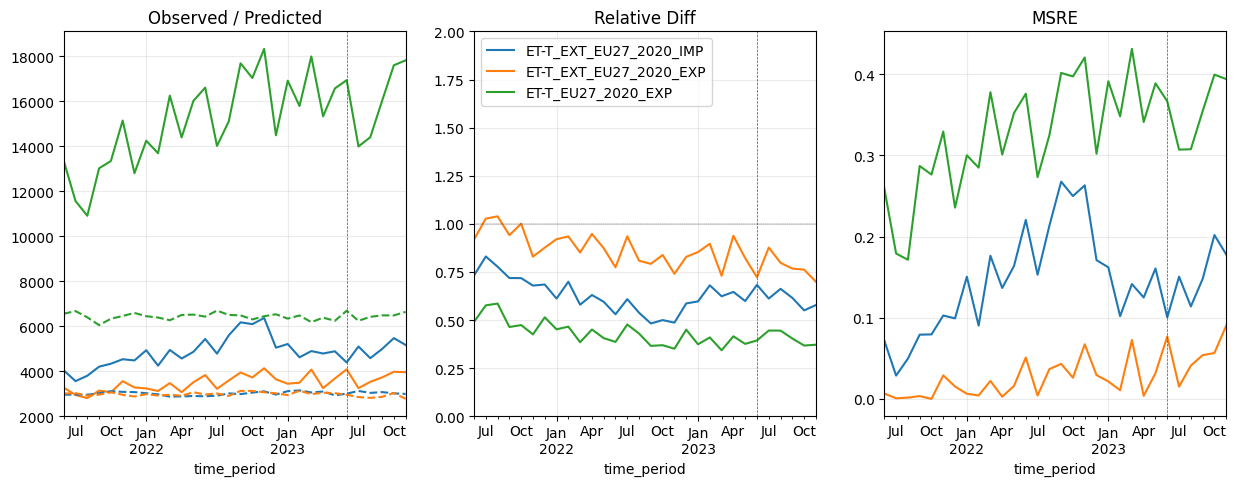

DE


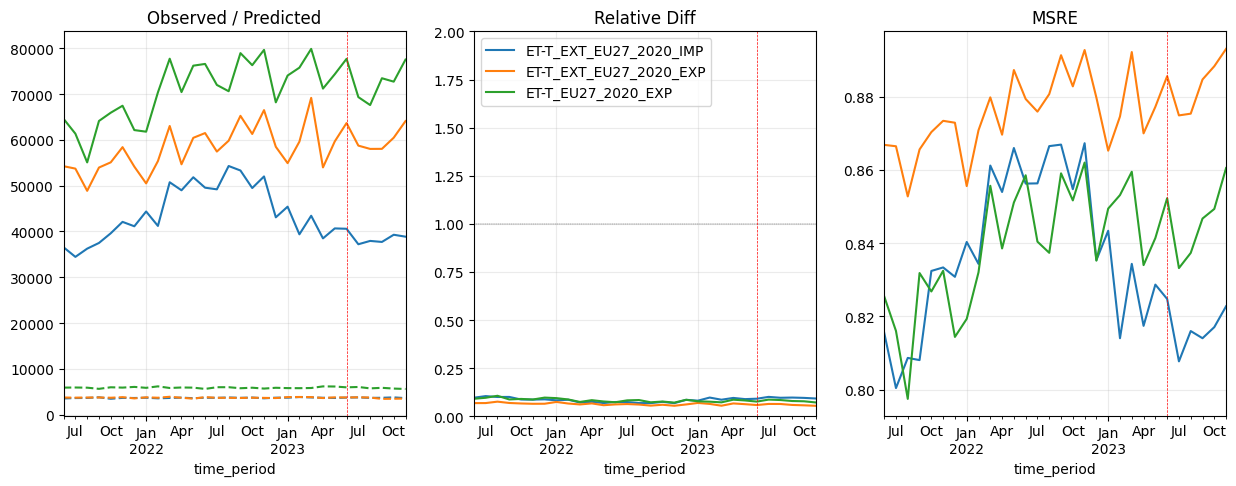

DK


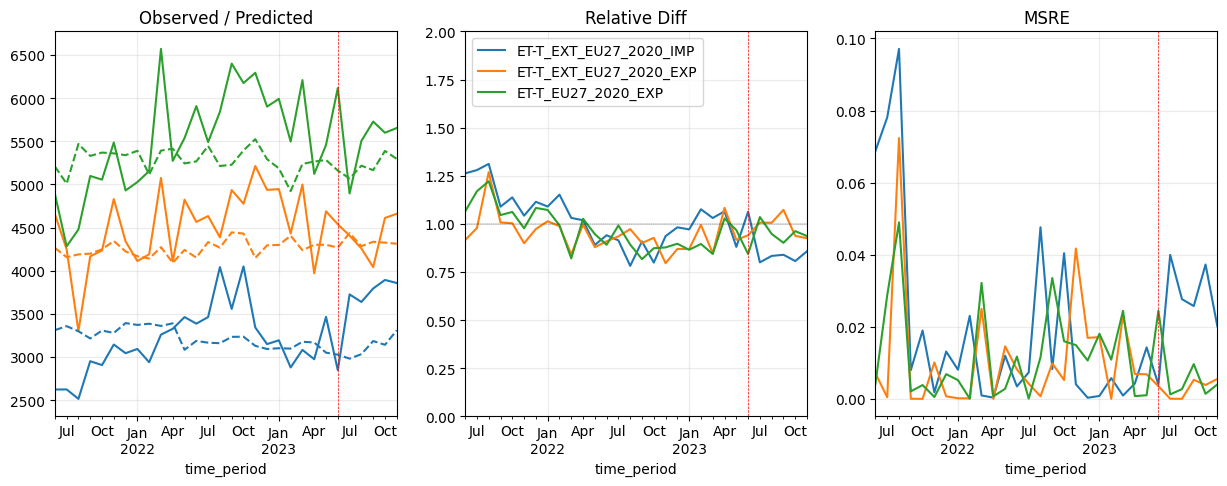

EE


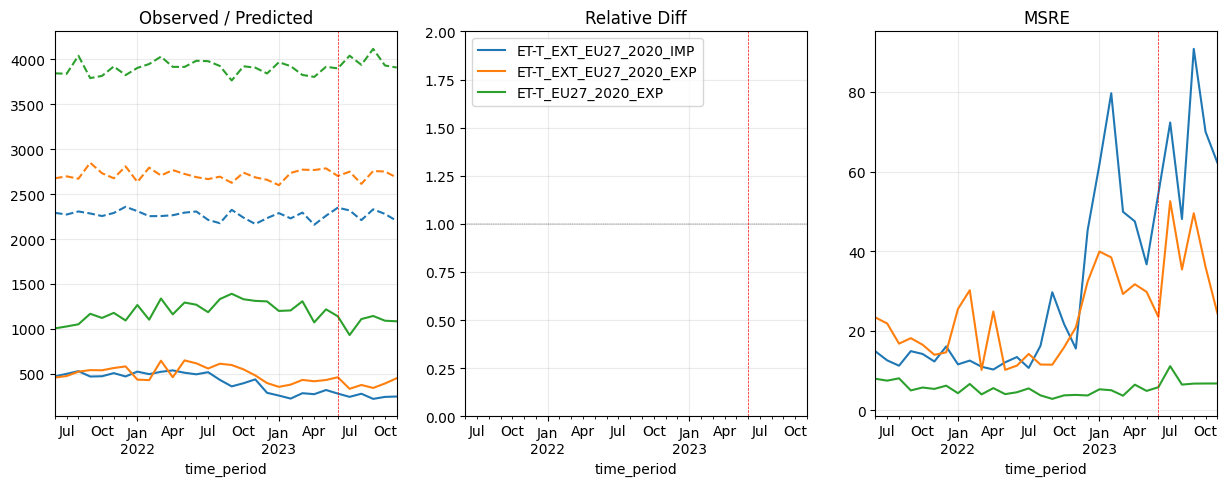

EL


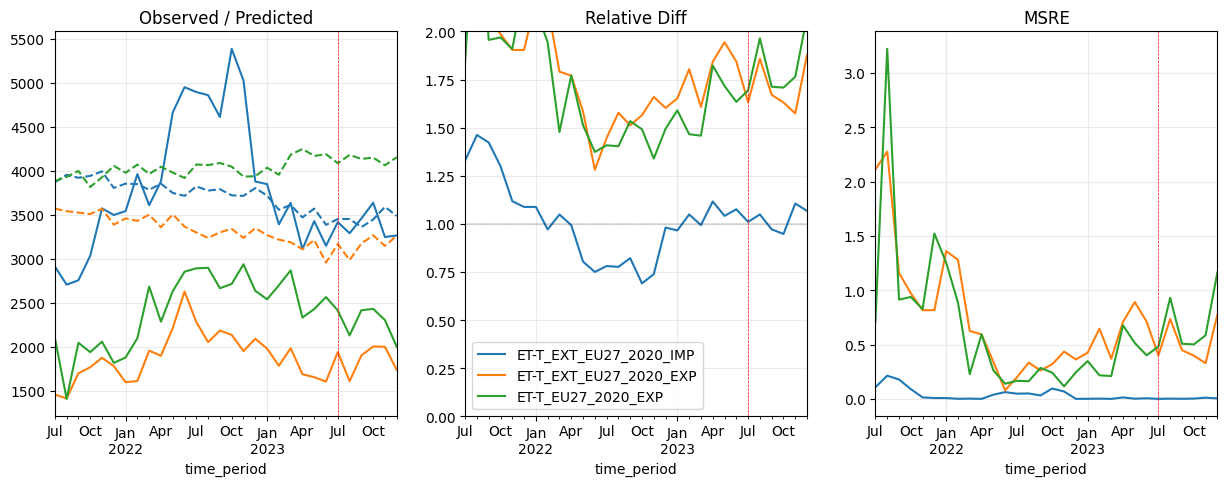

ES


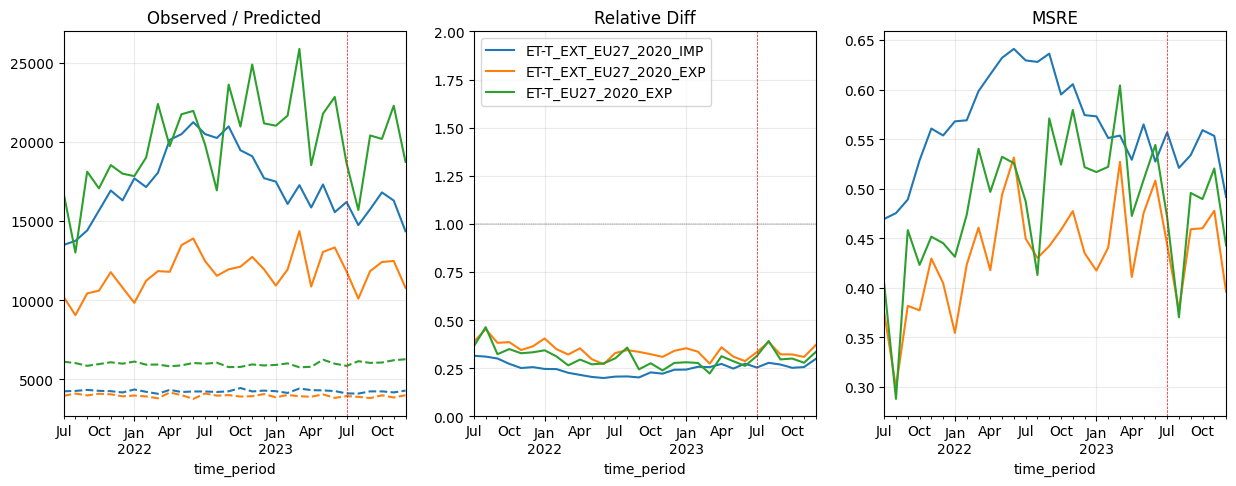

FI


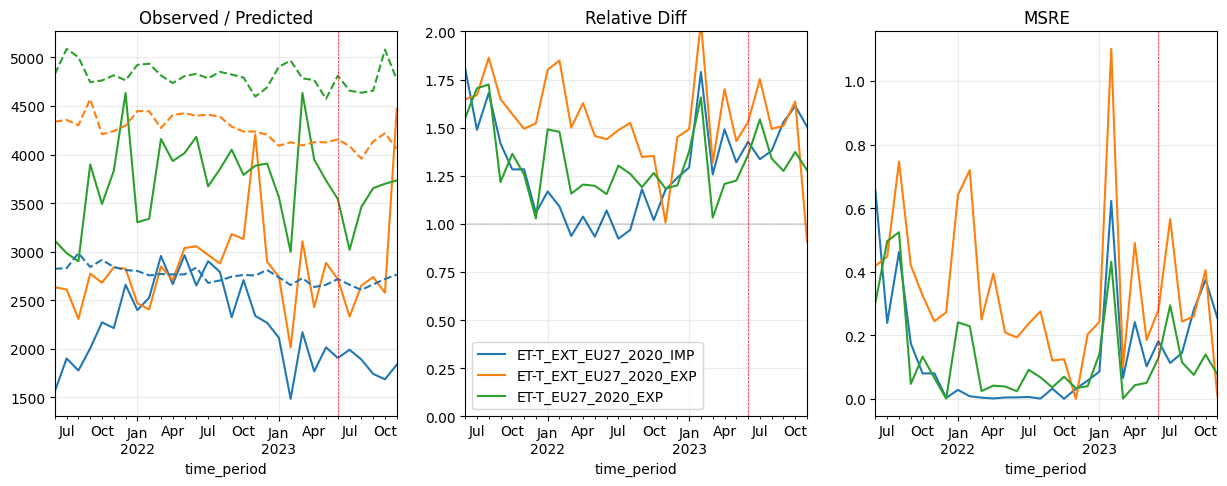

FR


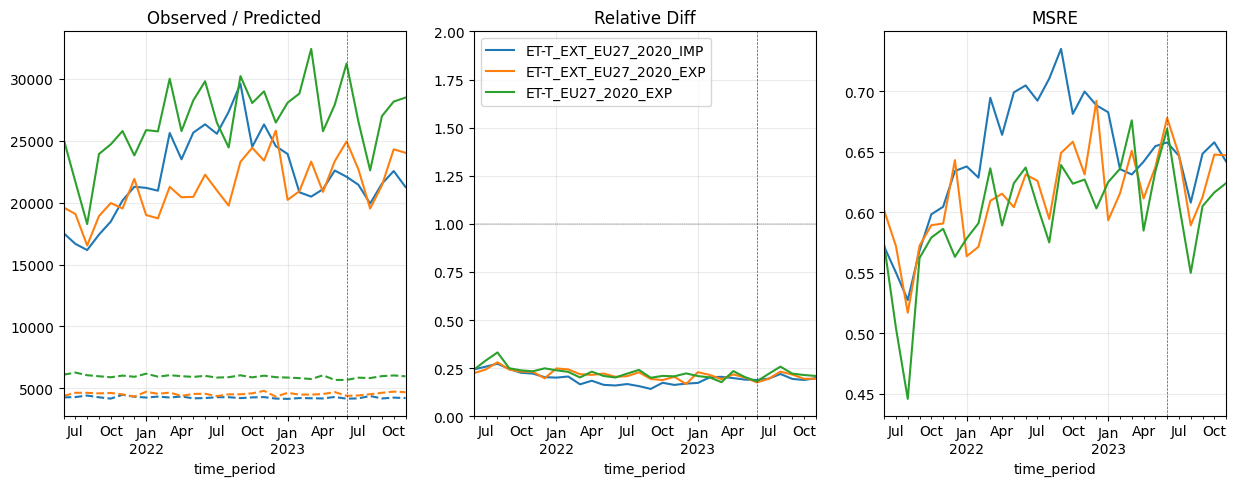

HR


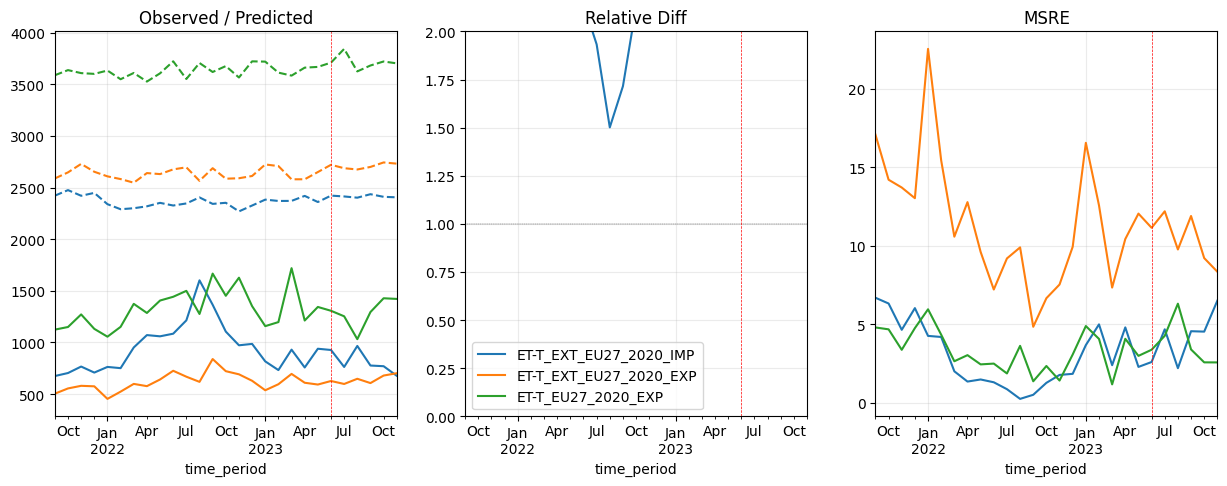

HU


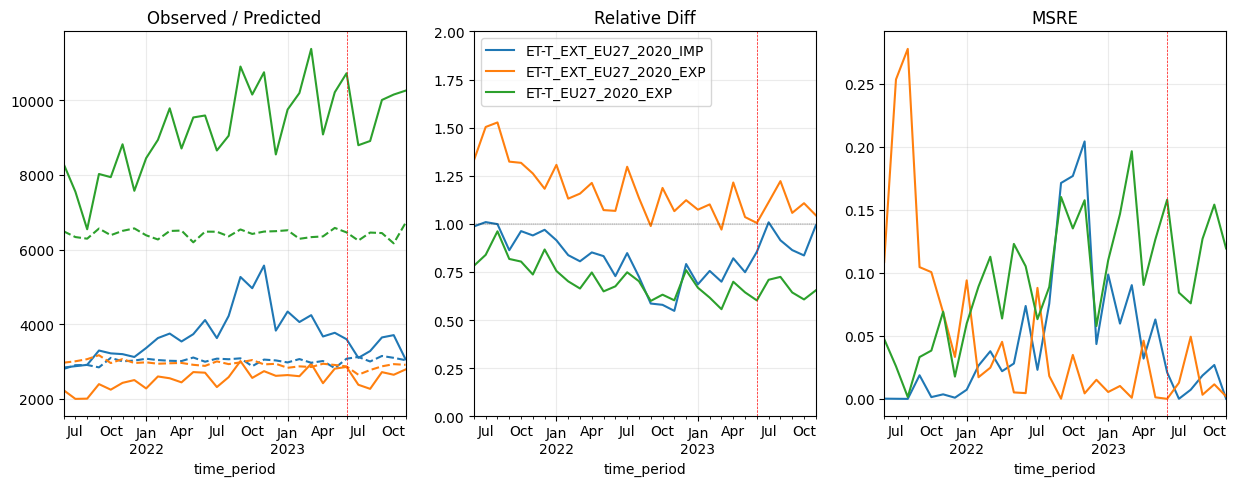

IE


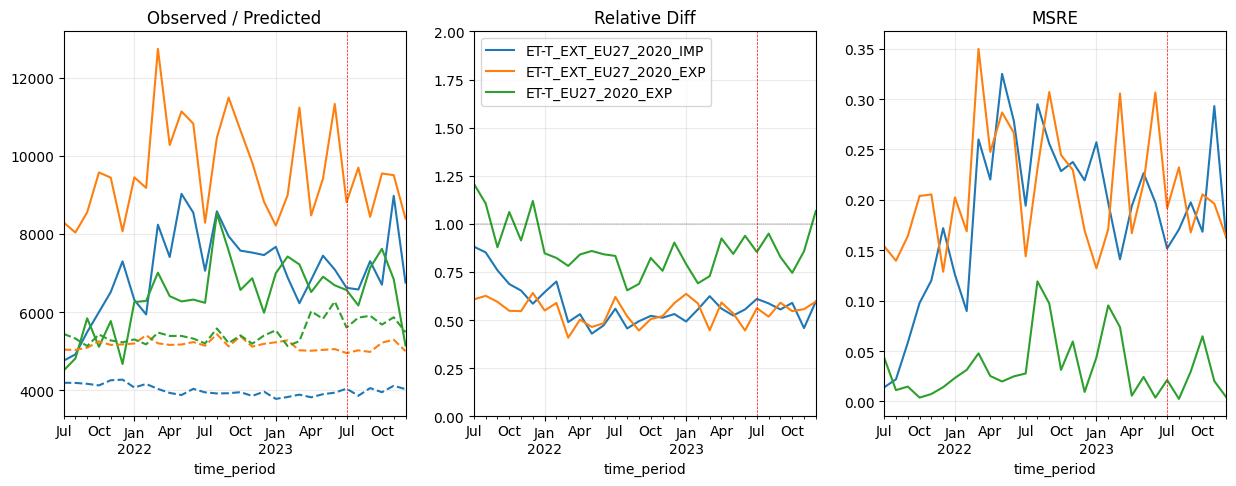

IT


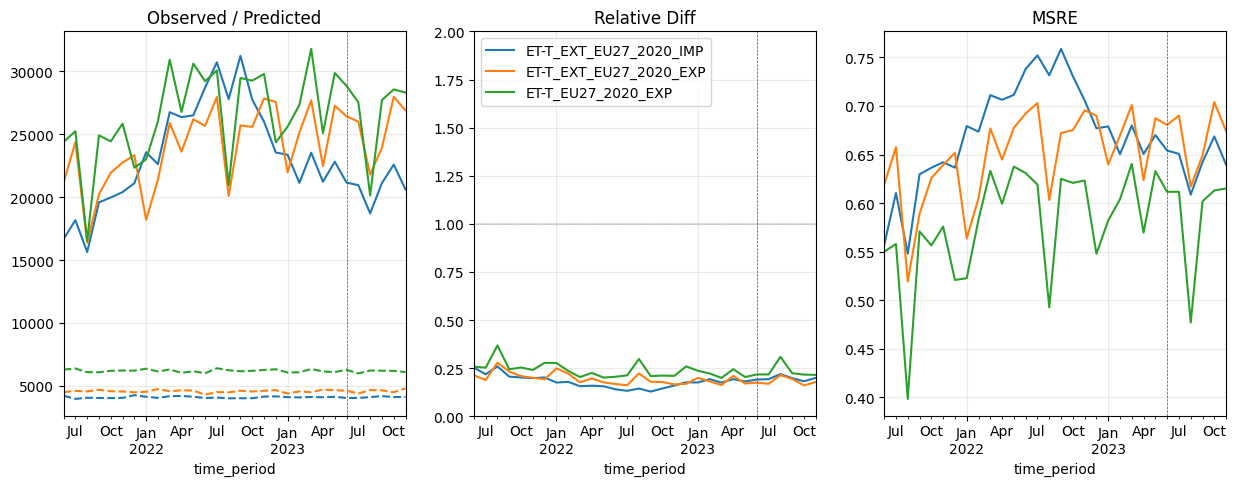

LT


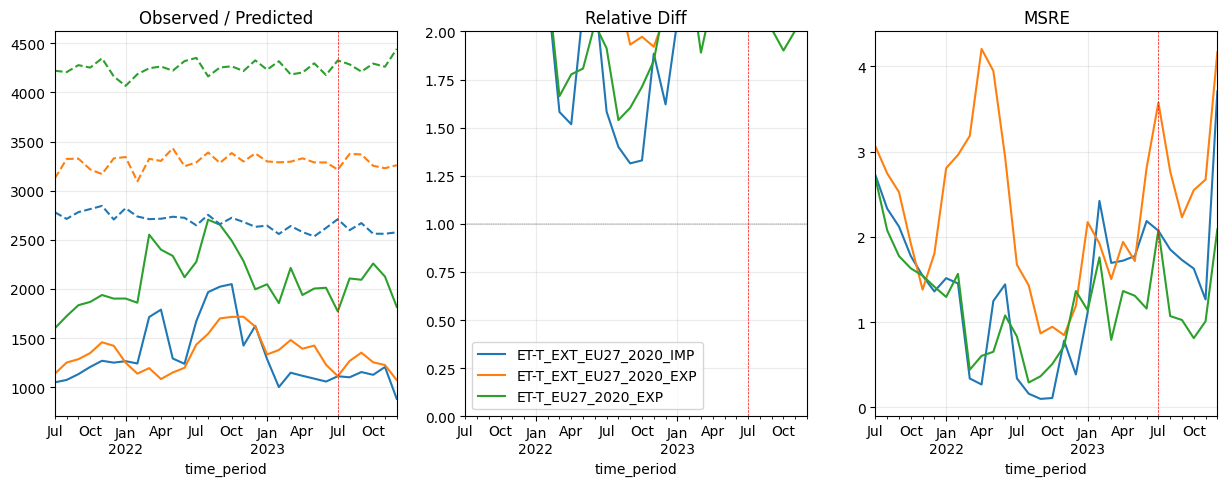

LU


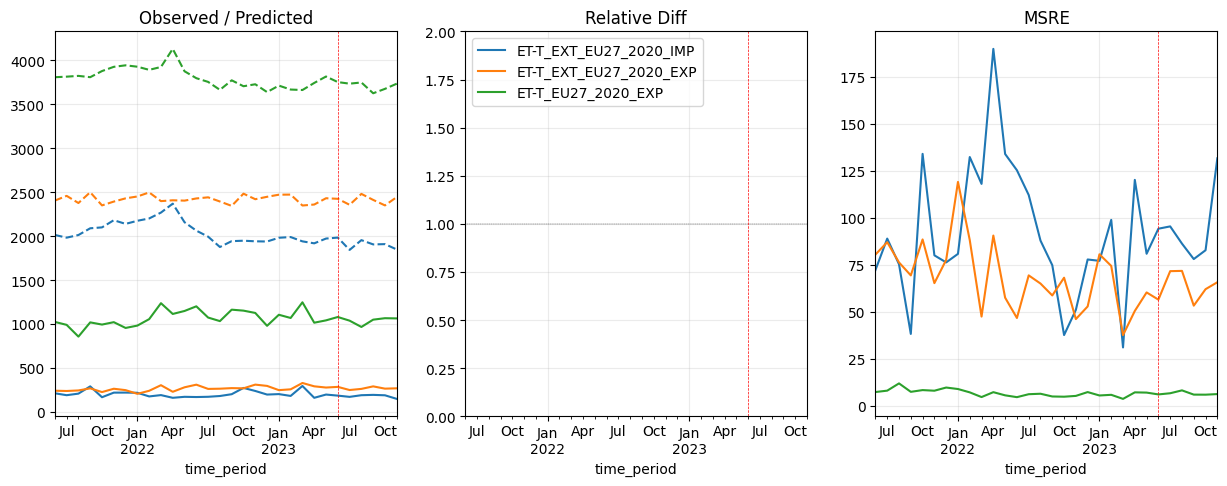

LV


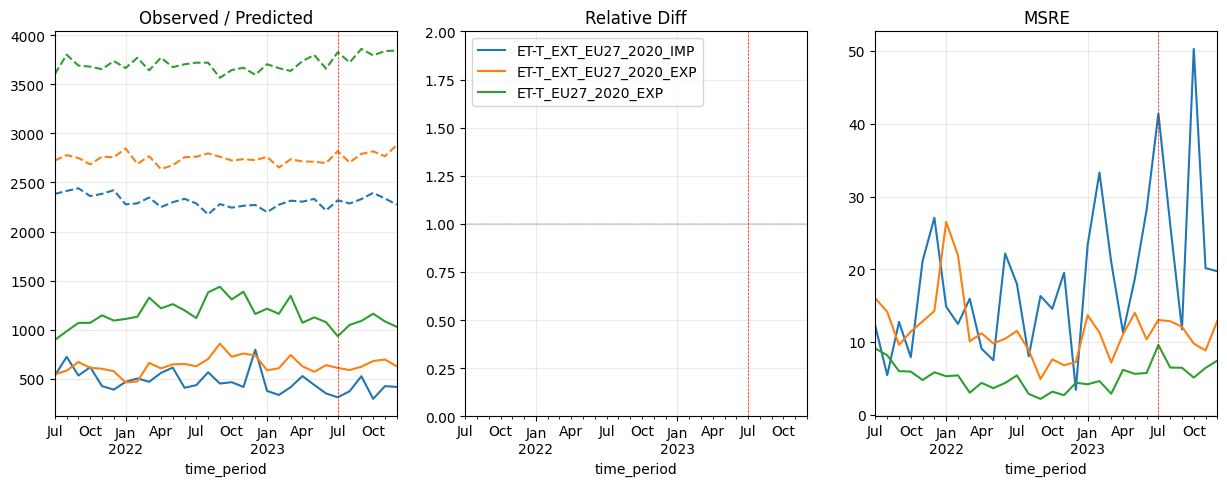

MT


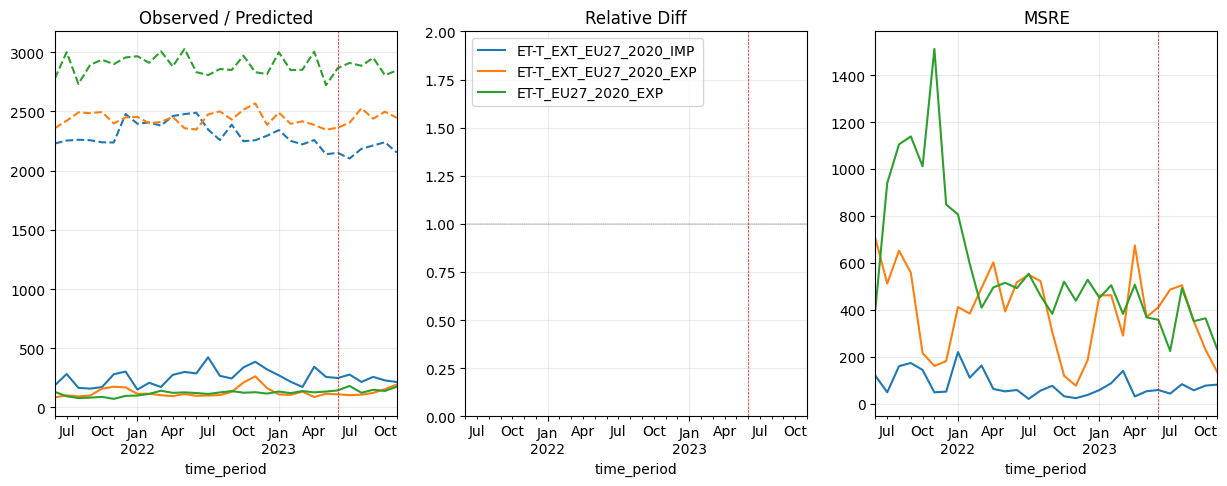

NL


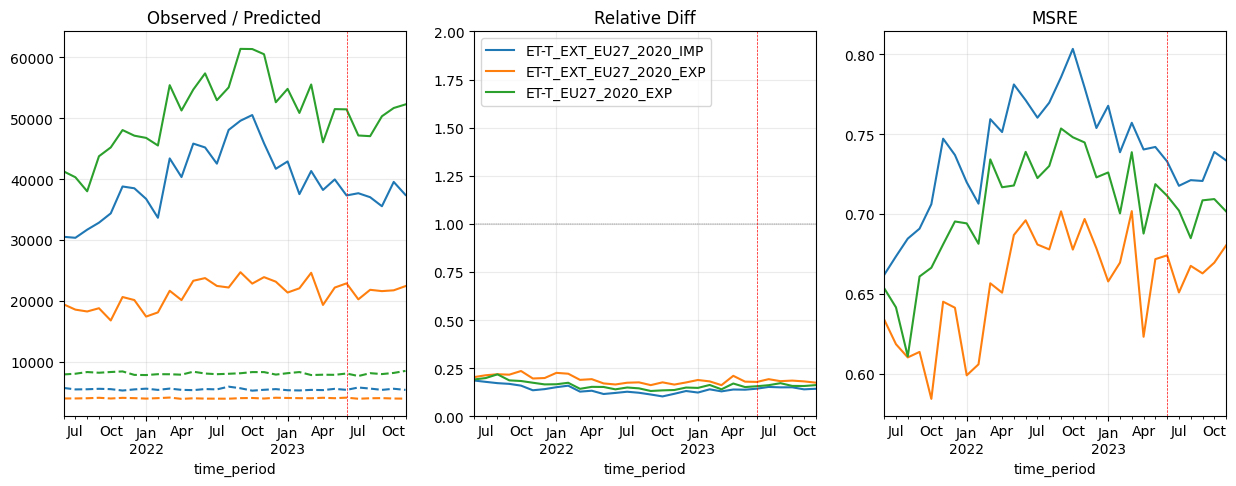

PL


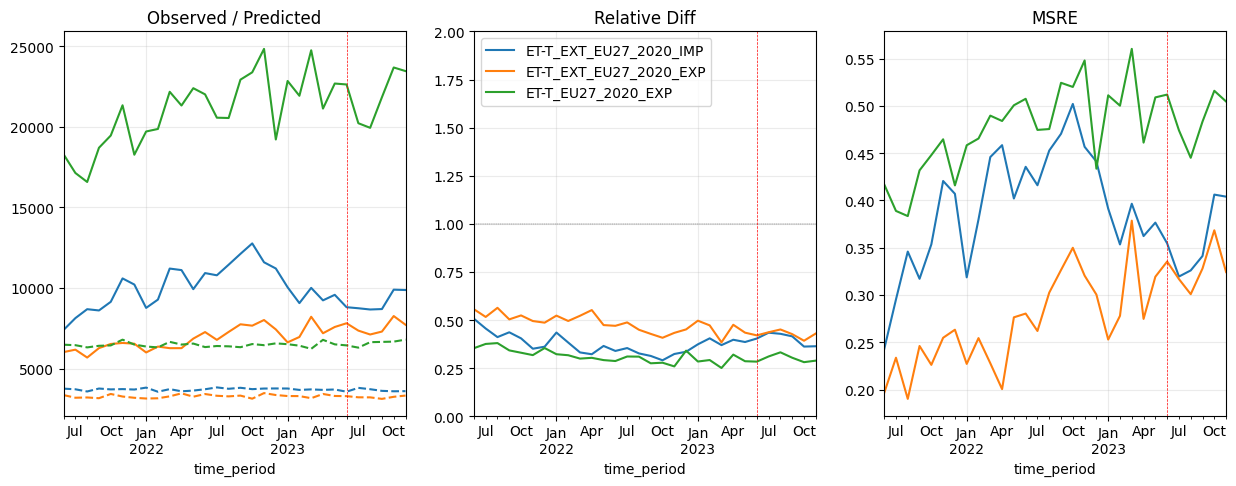

PT


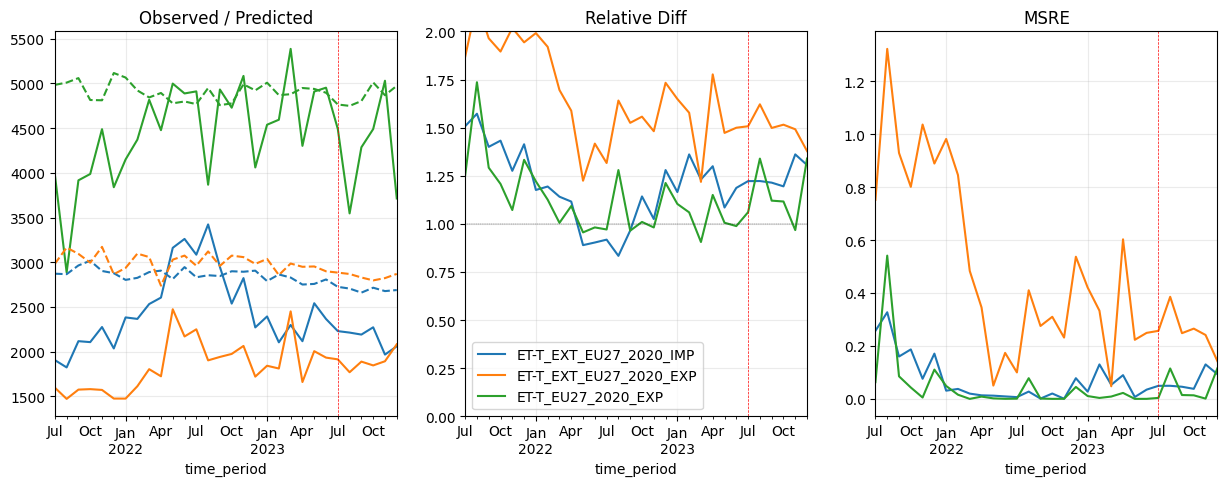

RO


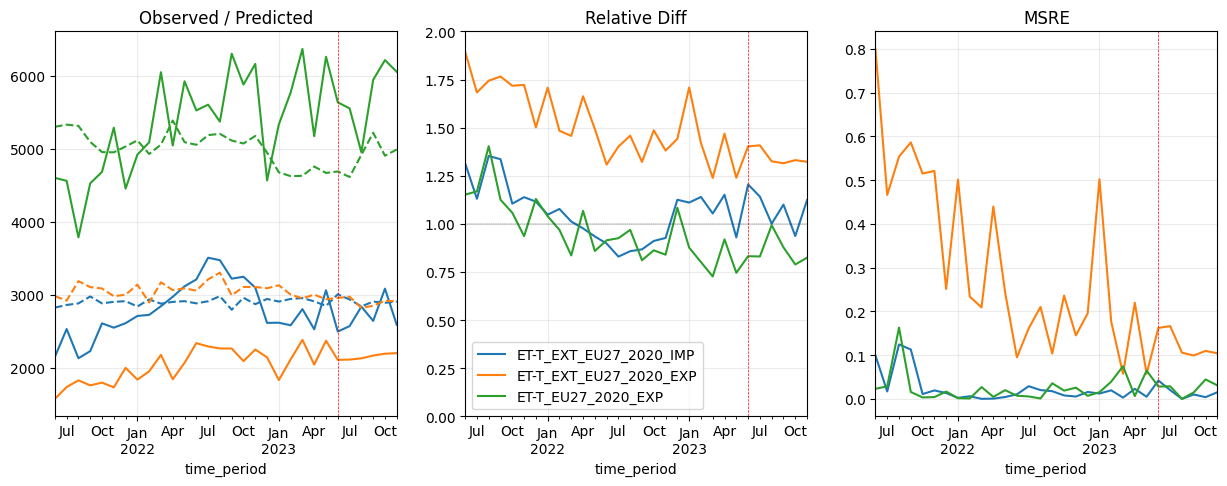

SE


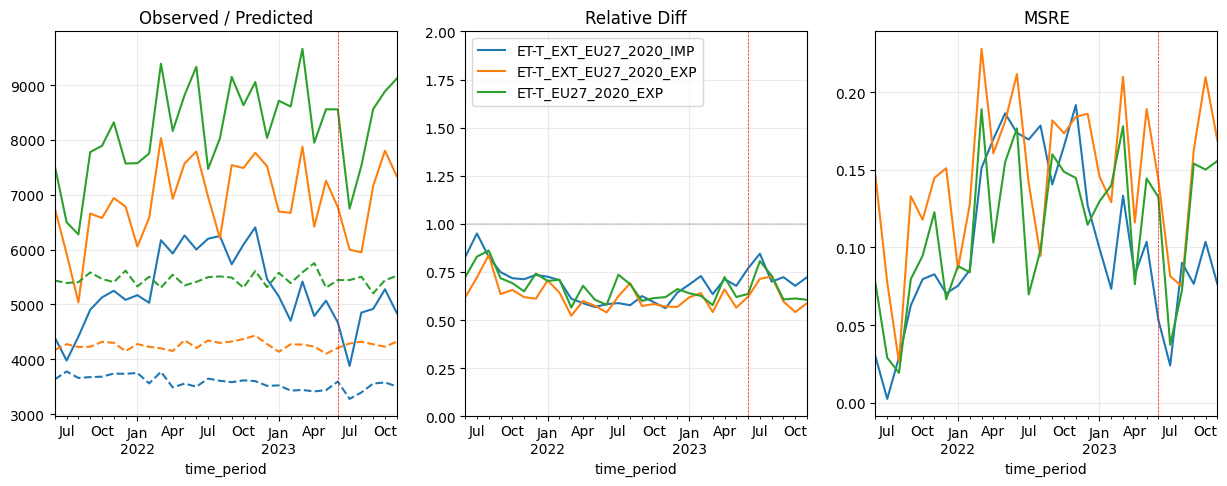

SI


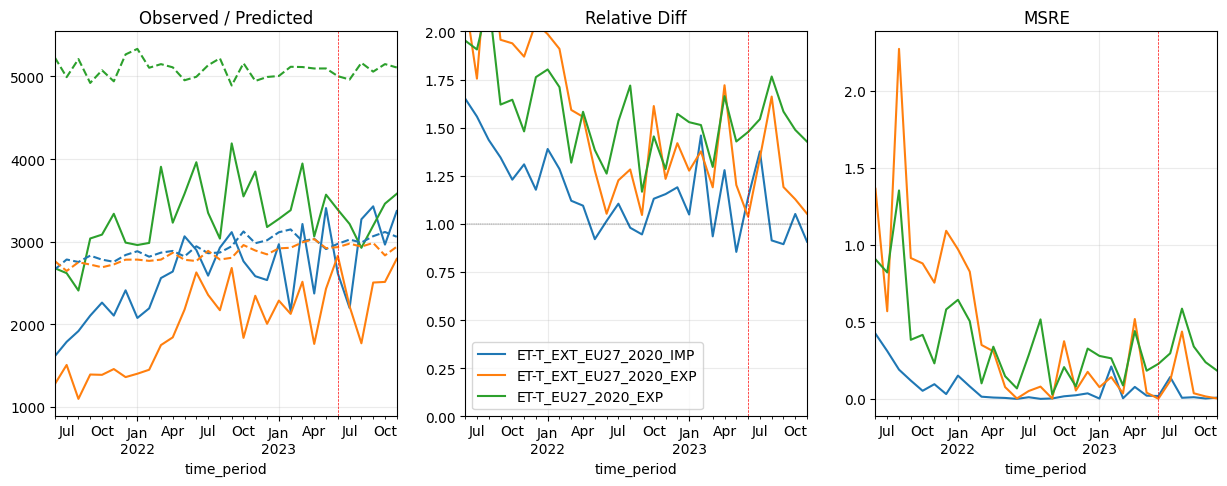

SK


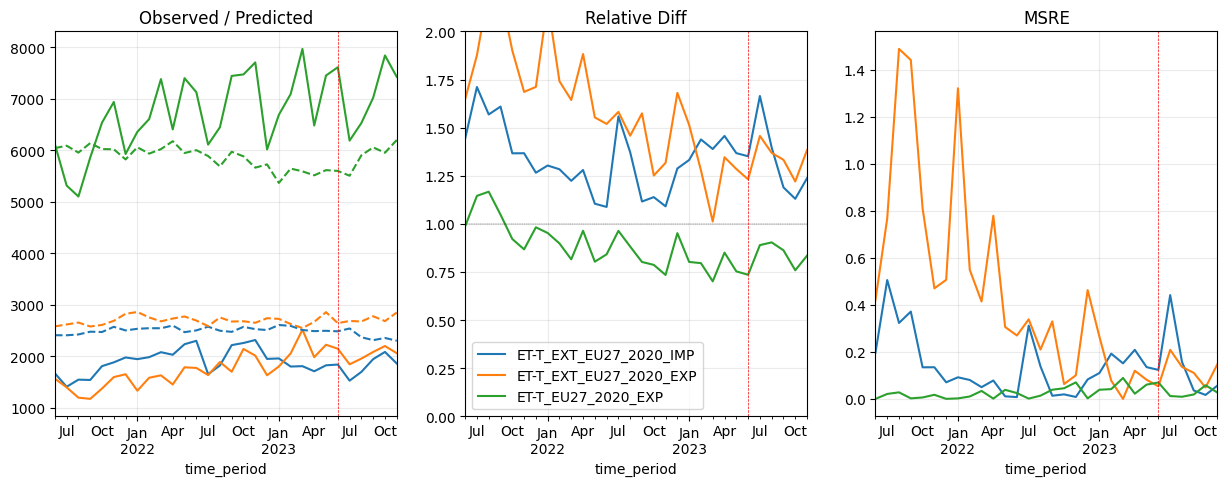

In [460]:
time_horizon = 3
n_months = 6


df_samples_temp = df_samples[df_samples['time_horizon'] == time_horizon]
df_samples_temp[my_cols] = df_samples_temp[my_cols].where(df_samples_temp[my_cols] > 0, 50)

preds = df_samples_temp.groupby(['geo', 'time_period'])[my_cols].median()
preds = preds.where(preds > 0, 0)

target = df_target[my_cols]
target = target.loc[preds.index]

diff = preds - target
diff_pct = diff / target
rel_diff = preds / target
msre_raw = (diff_pct) ** 2


for country in diff.index.get_level_values(0).unique():
    print(country)
    figg, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))

    # plot preds and targets    
    target.loc[country].plot(ax=ax0, legend=False, title='Observed / Predicted')
    ax0.set_prop_cycle(None)
    preds.loc[country].plot(ax=ax0, legend=False, linestyle='--')

    # plot diff
    rel_diff.loc[country].plot(ax=ax1, title='Relative Diff')
    ax1.axhline(1, color='black', linestyle='--', linewidth=.25)
    ax1.set_ylim(0, 2)
    # ax1.axvline(1, color='black', linestyle='--', linewidth=.25)


    # plot msre
    msre_raw.loc[country].plot(ax=ax2, legend=False, title='MSRE')

    for ax in [ax0, ax1, ax2]:
        ax.axvline(diff.loc[country].index[-n_months], color='r', linestyle='--', linewidth=.5)
        ax.grid(alpha=.25)   
    plt.show()

In [461]:
def run_ewm_search(preds, rel_diff):
    ewm_params = {
        'com': [i / 25 for i in range(25, 500, 25)],
        'span': [i / 25 for i in range(25, 500, 25)],
        'halflife': range(1, 100),
        'alpha': [i / 100 for i in range(1, 100, 5)]  # alpha should be between 0 and 1
    }

    yo_dict = {}
    for param_name, param_values in ewm_params.items():
        for param_value in param_values:
            # Create the keyword argument dynamically
            kwargs = {param_name: param_value}

            rel_diff_means = rel_diff.groupby('geo').apply(lambda x: x.ewm(**kwargs).mean().shift(3)).droplevel(0)
            new_preds = preds.div(rel_diff_means, axis=1)

            new_rmse = (((new_preds - target) / target) ** 2)

            yo_dict[(param_name, param_value)] = new_rmse.groupby('geo').tail(6).groupby('geo').mean()

    stacked = np.stack([x.values for x in yo_dict.values()])
    return yo_dict, stacked


def plot_adjusted_preds(c, yo_dict, stacked):
    # for a given country, find the beset params
    country_idx = [i for i, country in enumerate(target.index.get_level_values(0).unique()) if country == c][0]
    best_params_idx = stacked.argmin(axis=0)[country_idx][0]
    best_params = list(yo_dict.keys())[best_params_idx]
    best_params = {best_params[0]: best_params[1]}

    rel_diff_means = rel_diff.groupby('geo').apply(lambda x: x.ewm(**best_params).mean().shift(3)).droplevel(0)


    c_target = target
    c_preds = preds
    c_preds_2 = c_preds.div(rel_diff_means, axis=1)

    # two subpots side by side
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 6))

    c_target.loc[c].plot(ax=ax0, linewidth=2, title='Target, Preds, Adjusted Preds')
    ax0.set_prop_cycle(None)
    c_preds.loc[c].plot(ax=ax0, linestyle='--', alpha=.5, legend=False)
    ax0.set_prop_cycle(None)
    c_preds_2.loc[c].plot(ax=ax0, linestyle='--', linewidth=.5, legend=False)


    msre_raw_1 = ((c_preds - c_target) / c_target) ** 2
    msre_raw_2 = ((c_preds_2 - c_target) / c_target) ** 2

    msre_raw_1.loc[c].plot(ax=ax1, linestyle='--', title= 'MSRE, raw and adjusted')
    ax1.set_prop_cycle(None)
    msre_raw_2.loc[c].plot(ax=ax1,  linestyle='--', linewidth=.5, legend=False)

    for ax in [ax0, ax1]:
        ax1.grid(alpha=.25)
        ax.axvline(c_target.loc[c].index[-6], color='r', linestyle='--', linewidth=.5)

    plt.show()
    return pd.DataFrame({
        'raw': msre_raw_1.loc[c].tail(6).mean(),
        'adj': msre_raw_2.loc[c].tail(6).mean()
    })

In [462]:
df_samples, df_target = get_dfs(48)
df_samples

ET-T_EU27_2020_EXP  ET-T_EXT_EU27_2020_EXP  ET-T_EXT_EU27_2020_IMP  \
0              6490.923828             3503.767090             3069.086182   
1              6286.998535             3200.912109             2736.536865   
2              5442.626953             3109.295410             3123.335205   
3              6300.328125             4297.685547             2807.995117   
4              5890.959961             3647.047607             2511.531250   
...                    ...                     ...                     ...   
121045         5998.216309             3230.647705             2146.946777   
121046         6862.902832             2715.284668             1962.129761   
121047         6134.772461             2417.454102             2270.224121   
121048         5636.419434             2483.284912             2159.361816   
121049         5819.125000             3211.281738             2207.394775   

        pred_id geo base_period  time_horizon time_period  
0             0  AT  2021-03-01             1  2021-04-01  
1             0  AT  2021-03-01             2  2021-05-01  
2             0  AT  2021-03-01             3  2021-06-01  
3             1  AT  2021-03-01             1  2021-04-01  
4             1  AT  2021-03-01             2  2021-05-01  
...         ...  ..         ...           ...         ...  
121045       48  SK  2023-08-01             2  2023-10-01  
121046       48  SK  2023-08-01             3  2023-11-01  
121047       49  SK  2023-08-01             1  2023-09-01  
121048       49  SK  2023-08-01             2  2023-10-01  
121049       49  SK  2023-08-01             3  2023-11-01  

[121050 rows x 8 columns]

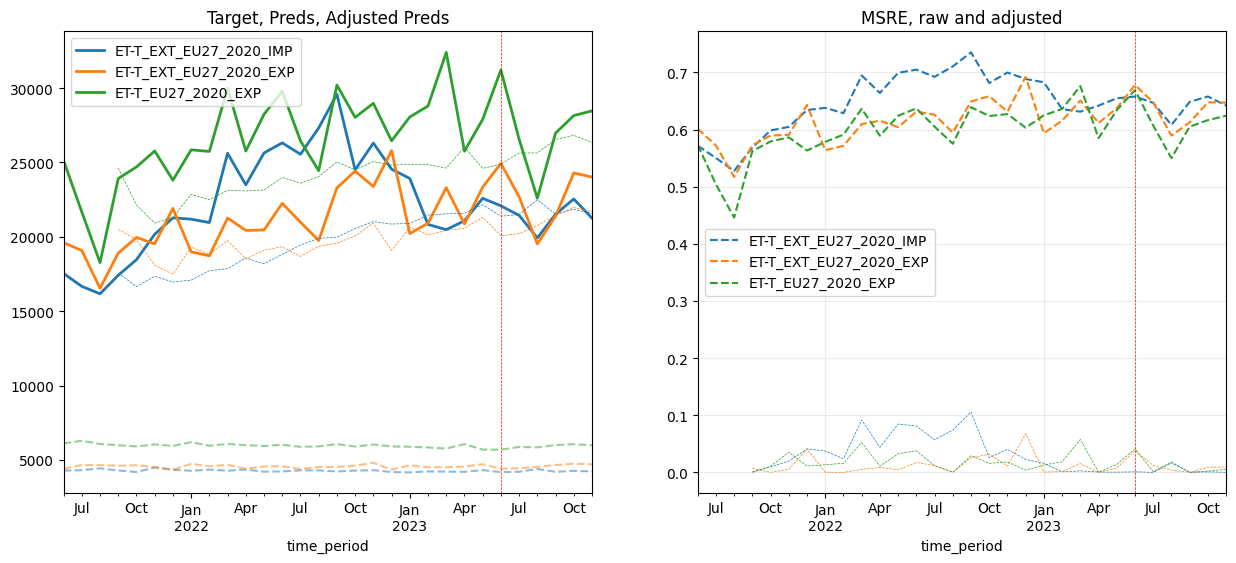

<Axes: >

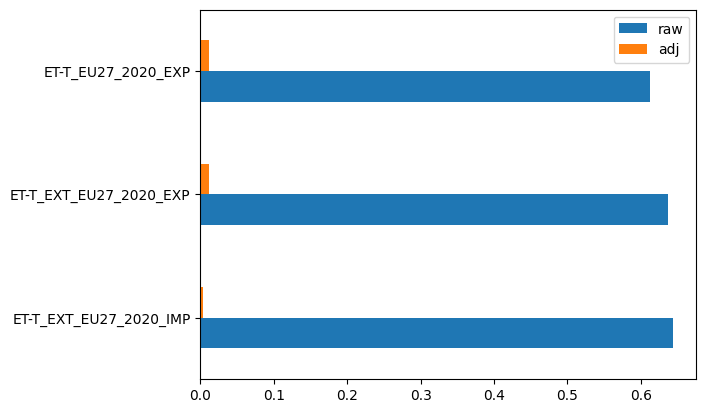

In [463]:
c = 'FR'

# to do: harmonize the two ewm search functions!
yo_dict, stacked = run_ewm_search(preds, rel_diff)
plot_adjusted_preds(c, yo_dict, stacked).plot.barh()

In [464]:
df_target.loc['SK'][TARGET_COLS].tail(15)

ET-T_EU27_2020_EXP  ET-T_EXT_EU27_2020_EXP  \
time_period                                               
2023-04-01               6481.8                  1981.8   
2023-05-01               7452.9                  2222.4   
2023-06-01               7613.4                  2146.1   
2023-07-01               6188.3                  1843.2   
2023-08-01               6530.5                  1954.0   
2023-09-01               7021.5                  2083.2   
2023-10-01               7842.9                  2197.8   
2023-11-01               7426.2                  2059.4   
2023-12-01               5706.9                  1744.1   
2024-01-01               6758.9                  1760.8   
2024-02-01               7066.1                  1826.2   
2024-03-01               7031.2                  1810.0   
2024-04-01               7127.3                  1917.7   
2024-05-01               7108.4                  2050.3   
2024-06-01               7074.6                  2076.3   

             ET-T_EXT_EU27_2020_IMP  
time_period                          
2023-04-01                   1707.7  
2023-05-01                   1823.7  
2023-06-01                   1838.3  
2023-07-01                   1525.6  
2023-08-01                   1695.9  
2023-09-01                   1943.8  
2023-10-01                   2083.6  
2023-11-01                   1859.3  
2023-12-01                   1552.2  
2024-01-01                   1693.4  
2024-02-01                   1658.0  
2024-03-01                   1653.9  
2024-04-01                   1749.1  
2024-05-01                   1841.4  
2024-06-01                   1615.9

In [465]:
raw_df.loc['SK'][TARGET_COLS].tail(15)

ET-T_EU27_2020_EXP  ET-T_EXT_EU27_2020_EXP  \
time_period                                               
2023-04-01               6481.8                  1981.8   
2023-05-01               7452.9                  2222.4   
2023-06-01               7613.4                  2146.1   
2023-07-01               6188.3                  1843.2   
2023-08-01               6530.5                  1954.0   
2023-09-01               7021.5                  2083.2   
2023-10-01               7842.9                  2197.8   
2023-11-01               7426.2                  2059.4   
2023-12-01               5706.9                  1744.1   
2024-01-01               6758.9                  1760.8   
2024-02-01               7066.1                  1826.2   
2024-03-01               7031.2                  1810.0   
2024-04-01               7127.3                  1917.7   
2024-05-01               7108.4                  2050.3   
2024-06-01               7074.6                  2076.3   

             ET-T_EXT_EU27_2020_IMP  
time_period                          
2023-04-01                   1707.7  
2023-05-01                   1823.7  
2023-06-01                   1838.3  
2023-07-01                   1525.6  
2023-08-01                   1695.9  
2023-09-01                   1943.8  
2023-10-01                   2083.6  
2023-11-01                   1859.3  
2023-12-01                   1552.2  
2024-01-01                   1693.4  
2024-02-01                   1658.0  
2024-03-01                   1653.9  
2024-04-01                   1749.1  
2024-05-01                   1841.4  
2024-06-01                   1615.9

In [353]:
yo[yo['geo'] == 'SK'].sort_values(['base_period','time_horizon'])

ET-T_EU27_2020_EXP  ET-T_EXT_EU27_2020_EXP  ET-T_EXT_EU27_2020_IMP  \
116550         5797.640625             3160.797607             2798.211914   
116553         4835.903809             2298.025635             1948.139648   
116556         5094.411133             3179.385742             2329.283691   
116559         5252.490723             2907.200195             2540.063721   
116562         7010.382324             2889.316406             2549.583984   
...                    ...                     ...                     ...   
121037         6128.384277             2584.850830             2861.188965   
121040         5878.772949             3000.093506             2249.260498   
121043         5494.171387             2644.255127             2119.444336   
121046         6862.902832             2715.284668             1962.129761   
121049         5819.125000             3211.281738             2207.394775   

        pred_id geo base_period  time_horizon time_period  
116550        0  SK  2021-03-01             1  2021-04-01  
116553        1  SK  2021-03-01             1  2021-04-01  
116556        2  SK  2021-03-01             1  2021-04-01  
116559        3  SK  2021-03-01             1  2021-04-01  
116562        4  SK  2021-03-01             1  2021-04-01  
...         ...  ..         ...           ...         ...  
121037       45  SK  2023-08-01             3  2023-11-01  
121040       46  SK  2023-08-01             3  2023-11-01  
121043       47  SK  2023-08-01             3  2023-11-01  
121046       48  SK  2023-08-01             3  2023-11-01  
121049       49  SK  2023-08-01             3  2023-11-01  

[4500 rows x 8 columns]

In [466]:
path = f'../save/Forecasting/euro_all_countries/n_samples_100_run_{run_id}_linear_False_sample_feat_True'
path

raw_df = pd.read_pickle(f'{path}/raw_df.pkl')

<Axes: xlabel='time_period'>

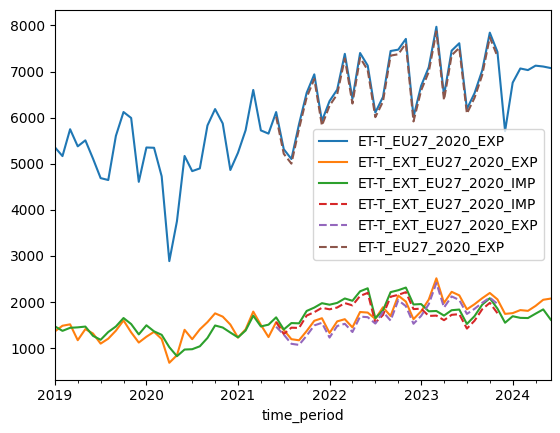

In [481]:
ax = raw_df.loc['SK'].loc['2019':][TARGET_COLS].plot()
(target.loc['SK'].loc['2019':] - 100).plot(ax=ax, linestyle='--')

In [482]:
def get_dfs(run_id):
    df_samples = pd.read_pickle(f'../save/Forecasting/euro_all_countries/n_samples_100_run_{run_id}_linear_False_sample_feat_True/df_samples.pkl')
    df_target = pd.read_pickle(f'../save/Forecasting/euro_all_countries/n_samples_100_run_{run_id}_linear_False_sample_feat_True/raw_df.pkl')

    return df_samples, df_target

def get_eval_data(df_samples, df_target, time_horizon):
    my_cols = [col for col in df_samples.columns if col in TARGET_COLS]
    yo_temp = df_samples[df_samples['time_horizon'] == time_horizon]
    yo_temp[my_cols] = yo_temp[my_cols].where(yo_temp[my_cols] > 0, 50)

    preds = yo_temp.groupby(['geo', 'time_period'])[my_cols].median()
    preds = preds.where(preds > 0, 0)

    target = df_target[my_cols]
    target = target.loc[preds.index]

    diff = preds - target
    diff_pct = diff / target
    rel_diff = preds / target
    msre_raw = (diff_pct) ** 2

    return {
        'preds': preds,
        'target': target,
        'diff': diff,
        'diff_pct': diff_pct,
        'rel_diff': rel_diff,
        'msre_raw': msre_raw
    } 


to_log = [31,32,33,34,35,36,37,38,39,40,41,42]


raw_msres = {}
for run_id in range(18, 50):
# for run_id in [18,19,40, 48, 49]:
    df_samples, df_target = get_dfs(run_id)
    my_cols = [col for col in df_samples.columns if col in TARGET_COLS]
    # print(my_cols)
    if run_id in to_log:
        # reverse log transform
        df_samples[my_cols] = np.exp(df_samples[my_cols])
        df_target[my_cols] = np.exp(df_target[my_cols])
    eval_data = get_eval_data(df_samples, df_target, 3)
    raw_msre = eval_data['msre_raw']
    raw_msre.index = pd.MultiIndex.from_tuples([(*x, run_id) for x in raw_msre.index], names=['country', 'time_period','run_id'])
    raw_msres[run_id] = raw_msre

# for run_id, eval_df in raw_msres.items():
#     # print(eval_df.index.names)
#     # add run_id to index
#     eval_df.index = pd.MultiIndex.from_tuples([(*x, run_id) for x in eval_df.index], names=['country', 'time_period','run_id'])

yo = pd.concat([v for v in raw_msres.values()]).sort_index()
min_date = yo.reset_index().groupby(['country','run_id'])['time_period'].min().min()
max_date = yo.reset_index().groupby(['country','run_id'])['time_period'].max().max()
min_date, max_date

(Timestamp('2021-06-01 00:00:00'), Timestamp('2024-07-01 00:00:00'))

<Axes: xlabel='run_id'>

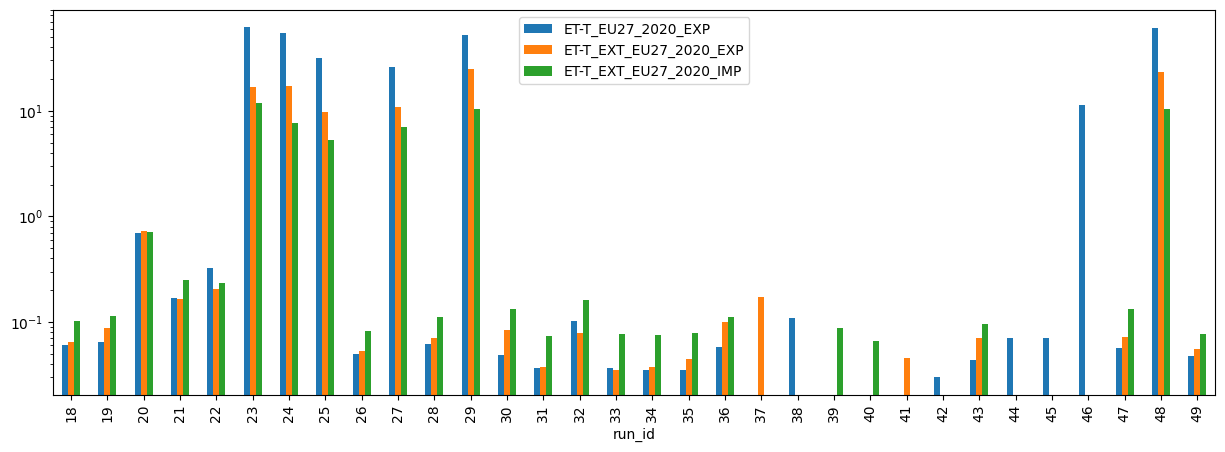

In [476]:
# slice yo's second level index to get between min and max date
gte_min = yo.index.get_level_values(1).values >= min_date
lte_max = yo.index.get_level_values(1).values <= max_date
# slice = [yo.index.get_level_values(1).values >= min_date & yo.index.get_level_values(1).values <= max_date]
yo = yo[gte_min & lte_max]
yo
yo.groupby(['country','run_id']).mean().groupby('run_id').mean().plot.bar(logy=True, figsize=(15,5))

In [528]:
print_comment([34,35,36])

34: base_data + "ET-CONXT" + new future, 36 mo, default params, LOG TRANSFORMS
35: base_data + "ET-CONXT" + BU/shorterm, 36 mo, default params, LOG TRANSFORMS
36: base_data + BU/shorterm, 36 mo, light params, LOG TRANSFORMS


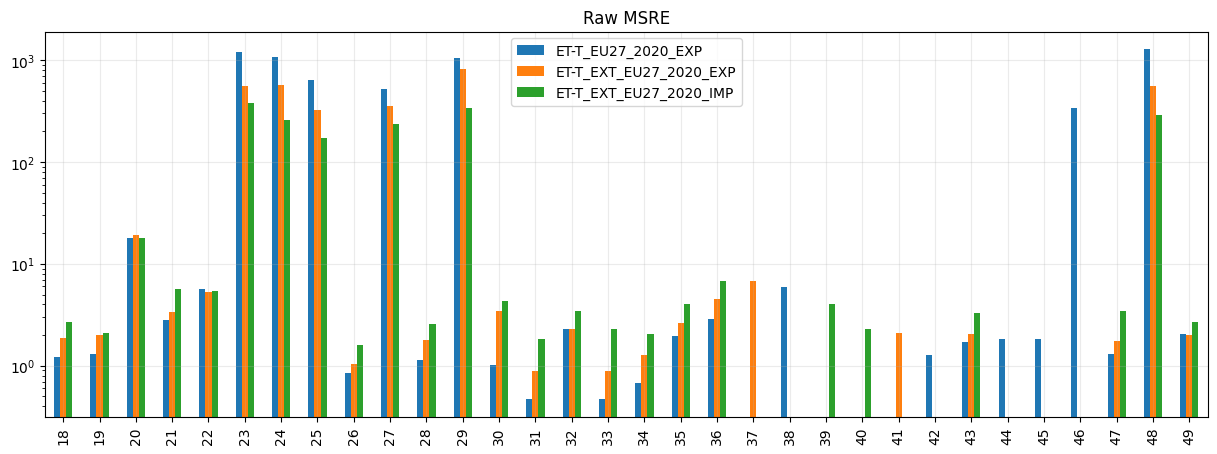

In [478]:
ax = df_raw_msres.plot.bar(logy=True, figsize=(15,5), title='Raw MSRE')
# ax.set_ylim(0, 1)
# plt.gca().invert_yaxis()
ax.grid(alpha=0.25)

In [1344]:
print_comment(31)

31: base_data, 36 mo, default params, but with log transforms before


<Axes: xlabel='time_period'>

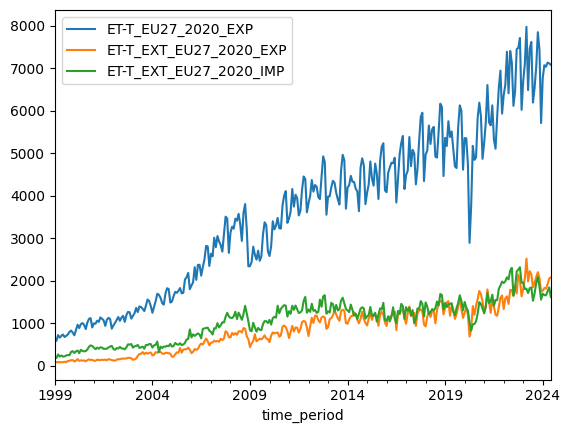

In [474]:
df_samples, df_target = get_dfs(48)

df_target.loc['SK'][TARGET_COLS].plot()

<Axes: xlabel='time_period'>

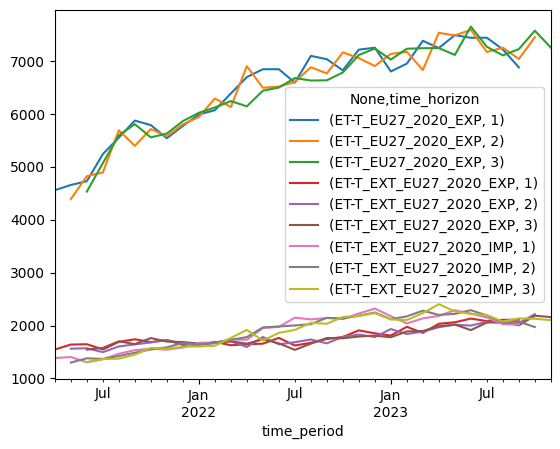

In [492]:
df_samples.groupby(['geo','time_horizon','time_period'])[TARGET_COLS].median().loc['SK'].unstack(0).plot()

In [1341]:
def make_analytics_df(targets, preds, run_id, country, start_time, all_cols):
    my_cols = [col for col in all_cols if col in TARGET_COLS]
    preds = preds.median(0).values
    preds = pd.DataFrame(preds, columns=all_cols)
    preds.index = pd.date_range(start_time, periods=preds.shape[0], freq='MS')
    preds.index += pd.DateOffset(months=36)

    targets = pd.DataFrame(targets, columns=all_cols)
    targets.index = pd.date_range(start_time, periods=targets.shape[0], freq='MS')

    df = pd.concat([targets[my_cols], preds[my_cols]], keys=['target','pred'], axis=1)
    # add contry and starttime levels to the df index with start time
    df.index = pd.MultiIndex.from_product([[run_id], [country], [start_time], df.index], names=['run_id', 'geo', 'start_time', 'time_period'])

    df['time_horizon'] = df['pred'].notna().any(axis=1).cumsum() 

    return df

def prep_analytics_df(run_id, input_length, log_runs, is_pred=False):
    # Load saved results from pickle files
    path = f'../save/Forecasting/euro_all_countries/n_samples_100_run_{run_id}_linear_False_sample_feat_True'

    if os.path.exists(path):
        if is_pred:
            output_path = path + '/predictions'
        else:
            output_path = path

        #find file name, it's either generated_outputs_nsample100.pk or generated_outputs_nsample50.pk
        if os.path.exists(output_path):
            filename = [f for f in os.listdir(output_path) if f.startswith('generated_outputs_nsample')][0]
            with open(f'{output_path}/{filename}', 'rb') as f:
                outputs = pickle.load(f)
                (all_generated_samples, all_target, all_evalpoint, 
                all_observed_point, all_observed_time, scaler, mean_scaler) = outputs

            # Validate the time horizon length
            time_horizon = all_generated_samples.shape[2] - input_length
            if time_horizon not in [3, 10]:
                raise ValueError(f'Unexpected series length: {time_horizon}')
            
            # Scale the samples back to original values
            all_generated_samples = all_generated_samples * scaler + mean_scaler
            all_target = all_target * scaler + mean_scaler

            if run_id in log_runs:
                all_generated_samples = np.exp(all_generated_samples)
                all_target = np.exp(all_target)
            
            # Load the original dataframe and indices for alignment
            df = pd.read_pickle(f'{path}/raw_df.pkl')

            df_indices = pd.read_pickle(f'{output_path}/df_indices.pkl')
            if is_pred:
                df_indices = df_indices[df_indices['split'] == 'predict']
            else:
                df_indices = df_indices[df_indices['split'] == 'test']
            
            # return all_generated_samples, df_indices
            # slice all_generated_samples to get only the relevant  prediction steps
            my_samples = all_generated_samples[:, :, -time_horizon:, :]

            out_df = pd.concat(
                [
                    make_analytics_df(target, sample, run_id, country, time_period, df.columns)
                    for (country, time_period), target, sample in zip(df_indices[['country', 'time_period']].values, all_target, my_samples)
                ]
            )
            return out_df


TARGET_COLS = ['ET-T_EU27_2020_EXP', 'ET-T_EXT_EU27_2020_EXP', 'ET-T_EXT_EU27_2020_IMP']
log_runs = [31,32,33,34,35,36,37,38,39,40,41,42]

run_id = 41

input_length = 36



# big_df = pd.concat(prep_analytics_df(run_id, input_length, log_runs) for run_id in range(18, 50))
big_df = pd.concat(prep_analytics_df(run_id, input_length, log_runs, is_pred=True) for run_id in range(45, 47))
# for run_id in range(18, 25):
#     sample_dict = prep_analytics_df(int(run_id), input_length, filename, log_runs)

# all_generated_samples, df_indices = outputs

<Axes: xlabel='start_time,time_period'>

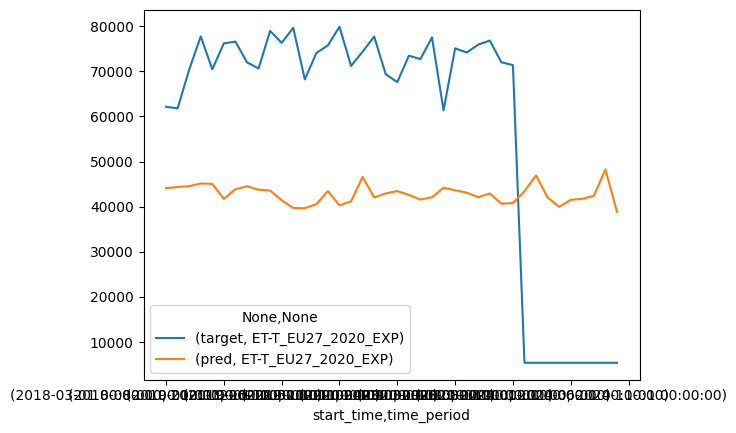

In [1343]:
big_df[big_df['time_horizon'] == 10].loc[45].loc['DE'][['target','pred']].plot()

In [1291]:
print_comment([45,46])

45: slim data, focus on EU27_2020_EXP + BU/shorterm + moy, 36 mo, light params
46: slim data, focus on EU27_2020_EXP + BU/shorterm + moy, 36 mo, light params, 3 pred steps


In [1325]:
path = f'../save/Forecasting/euro_all_countries/n_samples_100_run_45_linear_False_sample_feat_True/'
with open(f'{path}/predictions/generated_outputs_nsample50.pk', 'rb') as f:
    outputs = pickle.load(f)
    (all_generated_samples, all_target, all_evalpoint, 
    all_observed_point, all_observed_time, scaler, mean_scaler) = outputs

all_generated_samples.shape

torch.Size([888, 50, 39, 7])

In [1329]:
yo = all_generated_samples[0].median(0).values
yo * scaler + mean_scaler


tensor([[-1.5561e+05,  1.7615e+02, -3.1928e+01,  1.5835e+03, -3.2768e+04,
          7.8381e+04,  1.1248e+05],
        [-8.6980e+04,  1.9201e+02,  4.1556e+01,  9.0688e+02, -4.9406e+04,
          3.2787e+05,  7.3150e+04],
        [ 7.7673e+05, -2.8373e+01,  9.4207e+01,  6.0711e+02,  4.5078e+05,
         -4.8222e+03,  8.9821e+04],
        [-3.7772e+04,  1.0906e+02,  6.7293e+00, -1.2687e+02,  1.0759e+05,
          2.0873e+05,  8.4994e+04],
        [ 6.6925e+04,  1.3895e+02,  1.8259e+02,  5.9537e+02, -4.2044e+05,
          7.8655e+04,  4.7018e+04],
        [-1.6381e+05,  2.9404e+01,  1.0446e+02,  5.4372e+02,  3.1555e+05,
         -1.2416e+05,  4.6941e+04],
        [ 4.4082e+04,  2.8506e+02,  9.6781e+01, -5.2759e+02, -2.1551e+05,
          1.1015e+05,  1.2992e+05],
        [ 4.0652e+05,  1.3192e+02,  6.6775e+01, -1.4085e+03,  3.6107e+05,
          4.3133e+04, -1.4452e+05],
        [ 4.5170e+05,  8.1596e+01, -1.4960e+02,  8.9504e+01,  1.0131e+05,
          1.0082e+05, -2.7670e+03],
        [ 

In [1312]:
yo = pd.read_pickle(f'{path}/predictions/df_indices.pkl')
yo.groupby('split').size()

split
predict     888
test        807
train      4024
val         242
dtype: int64

In [1310]:
yo = pd.read_pickle(f'{path}/df_indices.pkl')
yo.groupby('split').size()

split
test      807
train    3457
val       242
dtype: int64

In [1318]:
yo = pd.read_pickle(f'{path}/predictions/raw_df.pkl')
yo

ET-T_EU27_2020_EXP  moy  short_term    BU  \
geo time_period                                              
AT  1999-01-01               3128.5    1    2.696455  -0.6   
    1999-02-01               3383.0    2    2.578952   5.6   
    1999-03-01               4107.7    3    2.626682   2.6   
    1999-04-01               3692.8    4    2.676455  17.8   
    1999-05-01               3543.3    5    2.695045  14.0   
...                             ...  ...         ...   ...   
SK  2024-02-01               7066.1    2    3.813652  19.8   
    2024-03-01               7031.2    3    3.724500  16.9   
    2024-04-01               7127.3    4    3.684826  17.7   
    2024-05-01               7108.4    5    3.547591  22.4   
    2024-06-01               7074.6    6    3.433714  25.4   

                 ET-INTER_EU27_2020_EXP  ET-CONS_EU27_2020_EXP  \
geo time_period                                                  
AT  1999-01-01                   1937.9                  672.5   
    1999-02-01                   2044.9                  761.5   
    1999-03-01                   2472.6                  922.3   
    1999-04-01                   2217.2                  818.4   
    1999-05-01                   2149.8                  777.6   
...                                 ...                    ...   
SK  2024-02-01                   3384.7                 2549.2   
    2024-03-01                   3276.2                 2589.5   
    2024-04-01                   3326.9                 2638.1   
    2024-05-01                   3181.1                 2862.6   
    2024-06-01                   3177.4                 2720.6   

                 ET-CAP_EU27_2020_EXP  
geo time_period                        
AT  1999-01-01                  505.5  
    1999-02-01                  566.7  
    1999-03-01                  695.9  
    1999-04-01                  644.5  
    1999-05-01                  603.8  
...                               ...  
SK  2024-02-01                 1081.1  
    2024-03-01                 1120.8  
    2024-04-01                 1104.0  
    2024-05-01                 1006.0  
    2024-06-01                 1031.9  

[8232 rows x 7 columns]

In [1281]:
yo = pd.read_pickle(f'{path}/raw_df.pkl')
yo

ET-T_EU27_2020_EXP  moy  short_term    BU  \
geo time_period                                              
AT  1999-01-01               3128.5    1    2.696455  -0.6   
    1999-02-01               3383.0    2    2.578952   5.6   
    1999-03-01               4107.7    3    2.626682   2.6   
    1999-04-01               3692.8    4    2.676455  17.8   
    1999-05-01               3543.3    5    2.695045  14.0   
...                             ...  ...         ...   ...   
SK  2024-02-01               7066.1    2    3.813652  19.8   
    2024-03-01               7031.2    3    3.724500  16.9   
    2024-04-01               7127.3    4    3.684826  17.7   
    2024-05-01               7108.4    5    3.547591  22.4   
    2024-06-01               7074.6    6    3.433714  25.4   

                 ET-INTER_EU27_2020_EXP  ET-CONS_EU27_2020_EXP  \
geo time_period                                                  
AT  1999-01-01                   1937.9                  672.5   
    1999-02-01                   2044.9                  761.5   
    1999-03-01                   2472.6                  922.3   
    1999-04-01                   2217.2                  818.4   
    1999-05-01                   2149.8                  777.6   
...                                 ...                    ...   
SK  2024-02-01                   3384.7                 2549.2   
    2024-03-01                   3276.2                 2589.5   
    2024-04-01                   3326.9                 2638.1   
    2024-05-01                   3181.1                 2862.6   
    2024-06-01                   3177.4                 2720.6   

                 ET-CAP_EU27_2020_EXP  
geo time_period                        
AT  1999-01-01                  505.5  
    1999-02-01                  566.7  
    1999-03-01                  695.9  
    1999-04-01                  644.5  
    1999-05-01                  603.8  
...                               ...  
SK  2024-02-01                 1081.1  
    2024-03-01                 1120.8  
    2024-04-01                 1104.0  
    2024-05-01                 1006.0  
    2024-06-01                 1031.9  

[8232 rows x 7 columns]

In [955]:
def add_multi_to_df(old_df, new_df, level_name):
    # Add a new level to the index of the new DataFrame
    new_df.columns = pd.MultiIndex.from_product([[level_name], new_df.columns])
    
    # Concatenate the old and new DataFrames
    return pd.concat([old_df, new_df], axis=1)

diff = big_df['pred'] - big_df['target']
new_big_df = add_multi_to_df(big_df, diff, 'diff')

diff_pct =  new_big_df['diff'] / new_big_df['target']
new_big_df = add_multi_to_df(new_big_df, diff_pct, 'diff_pct')

rel_diff = new_big_df['pred'] / new_big_df['target']
new_big_df = add_multi_to_df(new_big_df, rel_diff, 'rel_diff')

msre_raw = new_big_df['diff_pct'] ** 2
new_big_df = add_multi_to_df(new_big_df, msre_raw, 'msre_raw')



th = 3
new_big_df = new_big_df[new_big_df['time_horizon'] == th]

all_time_periods = new_big_df.reset_index().groupby('run_id')['time_period'].apply(set).values
common_time_periods = set.intersection(*all_time_periods)

new_big_df = new_big_df[new_big_df.index.get_level_values(3).isin(common_time_periods)]

new_big_df[:10]

target                         \
                                  ET-T_EU27_2020_EXP ET-T_EXT_EU27_2020_EXP   
run_id geo start_time time_period                                             
18     AT  2018-10-01 2021-12-01         9779.900391            4539.500000   
           2018-11-01 2022-01-01        10516.099609            4408.700195   
           2018-12-01 2022-02-01        10981.799805            4615.900391   
           2019-01-01 2022-03-01        13046.500000            5298.500000   
           2019-02-01 2022-04-01        11355.000000            4698.100098   
           2019-03-01 2022-05-01        12234.699219            5346.700195   
           2019-04-01 2022-06-01        12009.799805            5317.200195   
           2019-05-01 2022-07-01        11164.199219            5083.100098   
           2019-06-01 2022-08-01        10523.799805            4831.300293   
           2019-07-01 2022-09-01        12822.199219            5472.300293   

                                                                       pred  \
                                  ET-T_EXT_EU27_2020_IMP ET-T_EU27_2020_EXP   
run_id geo start_time time_period                                             
18     AT  2018-10-01 2021-12-01             4264.500000        9810.297852   
           2018-11-01 2022-01-01             4801.100098        9594.941406   
           2018-12-01 2022-02-01             3984.399902       10084.046875   
           2019-01-01 2022-03-01             4912.600098       10181.691406   
           2019-02-01 2022-04-01             4766.600098       10555.921875   
           2019-03-01 2022-05-01             4737.399902       10114.654297   
           2019-04-01 2022-06-01             4044.899902       10130.480469   
           2019-05-01 2022-07-01             3937.100098       10400.130859   
           2019-06-01 2022-08-01             4473.100098       10702.664062   
           2019-07-01 2022-09-01             4789.200195       10836.207031   

                                                          \
                                  ET-T_EXT_EU27_2020_EXP   
run_id geo start_time time_period                          
18     AT  2018-10-01 2021-12-01             4789.520020   
           2018-11-01 2022-01-01             4858.805664   
           2018-12-01 2022-02-01             4629.070801   
           2019-01-01 2022-03-01             5184.318359   
           2019-02-01 2022-04-01             5142.566895   
           2019-03-01 2022-05-01             5015.866699   
           2019-04-01 2022-06-01             5098.642090   
           2019-05-01 2022-07-01             5173.425781   
           2019-06-01 2022-08-01             5275.039062   
           2019-07-01 2022-09-01             5364.413086   

                                                         time_horizon  \
                                  ET-T_EXT_EU27_2020_IMP                
run_id geo start_time time_period                                       
18     AT  2018-10-01 2021-12-01             3454.445312            3   
           2018-11-01 2022-01-01             3560.225342            3   
           2018-12-01 2022-02-01             3520.923096            3   
           2019-01-01 2022-03-01             3643.586670            3   
           2019-02-01 2022-04-01             3515.390869            3   
           2019-03-01 2022-05-01             3772.693359            3   
           2019-04-01 2022-06-01             3979.537842            3   
           2019-05-01 2022-07-01             4059.003418            3   
           2019-06-01 2022-08-01             4330.327637            3   
           2019-07-01 2022-09-01             4208.671387            3   

                                                diff                         \
                                  ET-T_EU27_2020_EXP ET-T_EXT_EU27_2020_EXP   
run_id geo start_time time_period                                             
18     AT  2018-10-01 

In [956]:

def run_ewm_search(target, rel_diff):
    ewm_params = {
        'com': [i / 25 for i in range(25, 500, 25)],
        'span': [i / 25 for i in range(25, 500, 25)],
        'halflife': range(1, 100),
        'alpha': [i / 100 for i in range(1, 100, 5)]  # alpha should be between 0 and 1
    }

    all_rmses = []
    all_preds = []
    all_params = []
    for param_name, param_values in ewm_params.items():
        for param_value in param_values:
            # Create the keyword argument dynamically
            kwargs = {param_name: param_value}
            all_params.append(kwargs)

            rel_diff_means = rel_diff.ewm(**kwargs).mean().shift(3)

            new_pred = target.div(rel_diff_means)
            all_preds.append(new_pred)

            new_rmse = (((new_pred - target) / target) ** 2)
            all_rmses.append(new_rmse)

    all_rmses = np.stack(all_rmses)
    all_preds = np.stack(all_preds)
    all_params = np.stack(all_params)

    best_runs = all_rmses[:,-6:,:].mean(1).argmin(0)
    best_params = all_params[best_runs]
    best_preds = np.stack([all_preds[best_runs[i], :, i] for i in range(len(best_runs))]).T
    best_preds = pd.DataFrame(best_preds, columns=target.columns, index=target.index)
    return best_preds, best_params

adj_preds = []
adj_params = {}
for (run_id, geo), chunk in tqdm(new_big_df.groupby(['run_id','geo'])):
    best_preds, best_params = run_ewm_search(chunk['target'], chunk['rel_diff'])
    adj_preds.append(best_preds)
    adj_params[(run_id, geo)] = best_params

100%|██████████| 864/864 [00:37<00:00, 23.02it/s]


In [957]:
all_adj_preds = pd.concat(adj_preds)
all_adj_preds.loc[18].loc['AT']

ET-T_EU27_2020_EXP  ET-T_EXT_EU27_2020_EXP  \
start_time time_period                                               
2018-10-01 2021-12-01                  NaN                     NaN   
2018-11-01 2022-01-01                  NaN                     NaN   
2018-12-01 2022-02-01                  NaN                     NaN   
2019-01-01 2022-03-01         13006.075248             5021.910262   
2019-02-01 2022-04-01         11950.141547             4350.805713   
2019-03-01 2022-05-01         13073.544736             5085.213967   
2019-04-01 2022-06-01         13712.895502             5161.316534   
2019-05-01 2022-07-01         12478.229421             4859.889073   
2019-06-01 2022-08-01         12064.452161             4723.041670   
2019-07-01 2022-09-01         14854.031527             5414.639753   
2019-08-01 2022-10-01         13663.580035             5308.730235   
2019-09-01 2022-11-01         14138.503595             5608.760278   
2019-10-01 2022-12-01         11614.386416             4857.613207   
2019-11-01 2023-01-01         12980.299257             4640.055739   
2019-12-01 2023-02-01         13175.114953             4818.173898   
2020-01-01 2023-03-01         15820.797357             6111.065761   
2020-02-01 2023-04-01         12937.548317             4962.473968   
2020-03-01 2023-05-01         12975.981960             5183.152164   
2020-04-01 2023-06-01         13578.704236             5543.125734   
2020-05-01 2023-07-01         12328.031446             5288.169728   
2020-06-01 2023-08-01         11031.388371             5065.055864   
2020-07-01 2023-09-01         12574.229618             5241.267588   
2020-08-01 2023-10-01         13055.620539             5502.355828   
2020-09-01 2023-11-01         13762.827371             5486.216918   

                        ET-T_EXT_EU27_2020_IMP  
start_time time_period                          
2018-10-01 2021-12-01                      NaN  
2018-11-01 2022-01-01                      NaN  
2018-12-01 2022-02-01                      NaN  
2019-01-01 2022-03-01              6064.586715  
2019-02-01 2022-04-01              6159.838103  
2019-03-01 2022-05-01              5814.610983  
2019-04-01 2022-06-01              5099.468815  
2019-05-01 2022-07-01              5051.764828  
2019-06-01 2022-08-01              5712.307919  
2019-07-01 2022-09-01              5822.281956  
2019-08-01 2022-10-01              6102.802723  
2019-09-01 2022-11-01              6381.639812  
2019-10-01 2022-12-01              4622.032862  
2019-11-01 2023-01-01              6363.560933  
2019-12-01 2023-02-01              4997.622712  
2020-01-01 2023-03-01              5425.081374  
2020-02-01 2023-04-01              5204.499019  
2020-03-01 2023-05-01              5082.015813  
2020-04-01 2023-06-01              4565.778686  
2020-05-01 2023-07-01              4529.813968  
2020-06-01 2023-08-01              3603.452756  
2020-07-01 2023-09-01              4136.264070  
2020-08-01 2023-10-01              4019.845936  
2020-09-01 2023-11-01              3793.625849

In [958]:

new_big_df = add_multi_to_df(new_big_df, all_adj_preds, 'adj_pred')


diff = new_big_df['adj_pred'] - new_big_df['target']
new_big_df = add_multi_to_df(new_big_df, diff, 'adj_diff')

diff_pct =  new_big_df['adj_diff'] / new_big_df['target']
new_big_df = add_multi_to_df(new_big_df, diff_pct, 'adj_diff_pct')


msre_raw = new_big_df['adj_diff_pct'] ** 2
new_big_df = add_multi_to_df(new_big_df, msre_raw, 'msre_adj')

new_big_df[:10]

target                         \
                                  ET-T_EU27_2020_EXP ET-T_EXT_EU27_2020_EXP   
run_id geo start_time time_period                                             
18     AT  2018-10-01 2021-12-01         9779.900391            4539.500000   
           2018-11-01 2022-01-01        10516.099609            4408.700195   
           2018-12-01 2022-02-01        10981.799805            4615.900391   
           2019-01-01 2022-03-01        13046.500000            5298.500000   
           2019-02-01 2022-04-01        11355.000000            4698.100098   
           2019-03-01 2022-05-01        12234.699219            5346.700195   
           2019-04-01 2022-06-01        12009.799805            5317.200195   
           2019-05-01 2022-07-01        11164.199219            5083.100098   
           2019-06-01 2022-08-01        10523.799805            4831.300293   
           2019-07-01 2022-09-01        12822.199219            5472.300293   

                                                                       pred  \
                                  ET-T_EXT_EU27_2020_IMP ET-T_EU27_2020_EXP   
run_id geo start_time time_period                                             
18     AT  2018-10-01 2021-12-01             4264.500000        9810.297852   
           2018-11-01 2022-01-01             4801.100098        9594.941406   
           2018-12-01 2022-02-01             3984.399902       10084.046875   
           2019-01-01 2022-03-01             4912.600098       10181.691406   
           2019-02-01 2022-04-01             4766.600098       10555.921875   
           2019-03-01 2022-05-01             4737.399902       10114.654297   
           2019-04-01 2022-06-01             4044.899902       10130.480469   
           2019-05-01 2022-07-01             3937.100098       10400.130859   
           2019-06-01 2022-08-01             4473.100098       10702.664062   
           2019-07-01 2022-09-01             4789.200195       10836.207031   

                                                          \
                                  ET-T_EXT_EU27_2020_EXP   
run_id geo start_time time_period                          
18     AT  2018-10-01 2021-12-01             4789.520020   
           2018-11-01 2022-01-01             4858.805664   
           2018-12-01 2022-02-01             4629.070801   
           2019-01-01 2022-03-01             5184.318359   
           2019-02-01 2022-04-01             5142.566895   
           2019-03-01 2022-05-01             5015.866699   
           2019-04-01 2022-06-01             5098.642090   
           2019-05-01 2022-07-01             5173.425781   
           2019-06-01 2022-08-01             5275.039062   
           2019-07-01 2022-09-01             5364.413086   

                                                         time_horizon  \
                                  ET-T_EXT_EU27_2020_IMP                
run_id geo start_time time_period                                       
18     AT  2018-10-01 2021-12-01             3454.445312            3   
           2018-11-01 2022-01-01             3560.225342            3   
           2018-12-01 2022-02-01             3520.923096            3   
           2019-01-01 2022-03-01             3643.586670            3   
           2019-02-01 2022-04-01             3515.390869            3   
           2019-03-01 2022-05-01             3772.693359            3   
           2019-04-01 2022-06-01             3979.537842            3   
           2019-05-01 2022-07-01             4059.003418            3   
           2019-06-01 2022-08-01             4330.327637            3   
           2019-07-01 2022-09-01             4208.671387            3   

                                                diff                         \
                                  ET-T_EU27_2020_EXP ET-T_EXT_EU27_2020_EXP   
run_id geo start_time time_period                                             
18     AT  2018-10-01 

ET-T_EU27_2020_EXP        36
ET-T_EXT_EU27_2020_EXP    35
ET-T_EXT_EU27_2020_IMP    49
dtype: int64
ET-T_EU27_2020_EXP        0.007013
ET-T_EXT_EU27_2020_EXP    0.013300
ET-T_EXT_EU27_2020_IMP    0.010659
dtype: float64


<Axes: xlabel='run_id'>

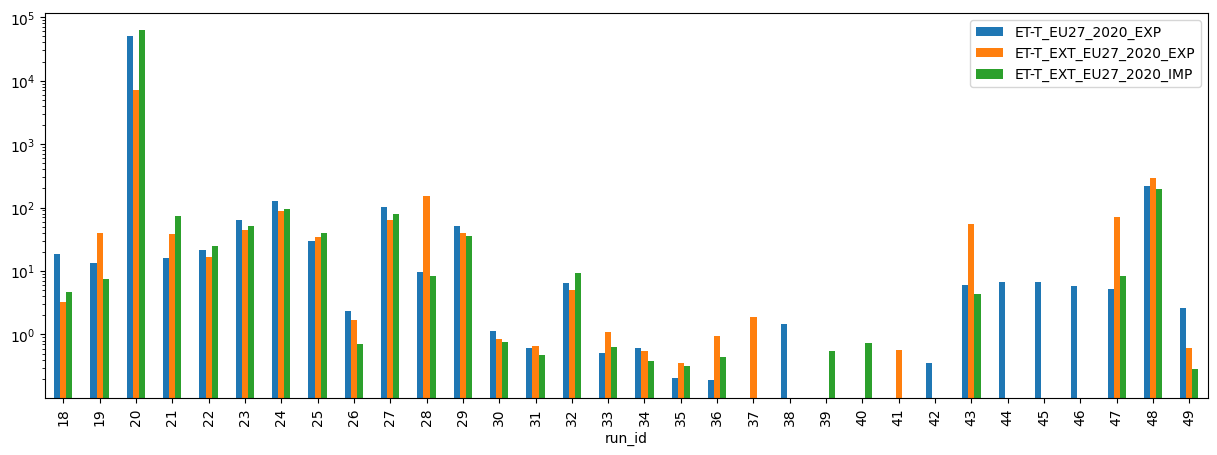

In [1001]:
def get_final_rmse(df, col):
    # calculate the run-level sum of the average for each counry's final 6 months of 
    return df[col].groupby(['run_id','geo']).tail(6).groupby(['run_id','geo']).mean().groupby('run_id').sum()

final_msre_adj = get_final_rmse(new_big_df, 'msre_adj')
print(final_msre_adj.where(final_msre_adj > 0, np.nan).idxmin())
print(final_msre_adj.where(final_msre_adj > 0, np.nan).min() / 27)
final_msre_adj.plot.bar(logy=True, figsize=(15,5))

ET-T_EU27_2020_EXP        31
ET-T_EXT_EU27_2020_EXP    31
ET-T_EXT_EU27_2020_IMP    31
dtype: int64


<Axes: xlabel='run_id'>

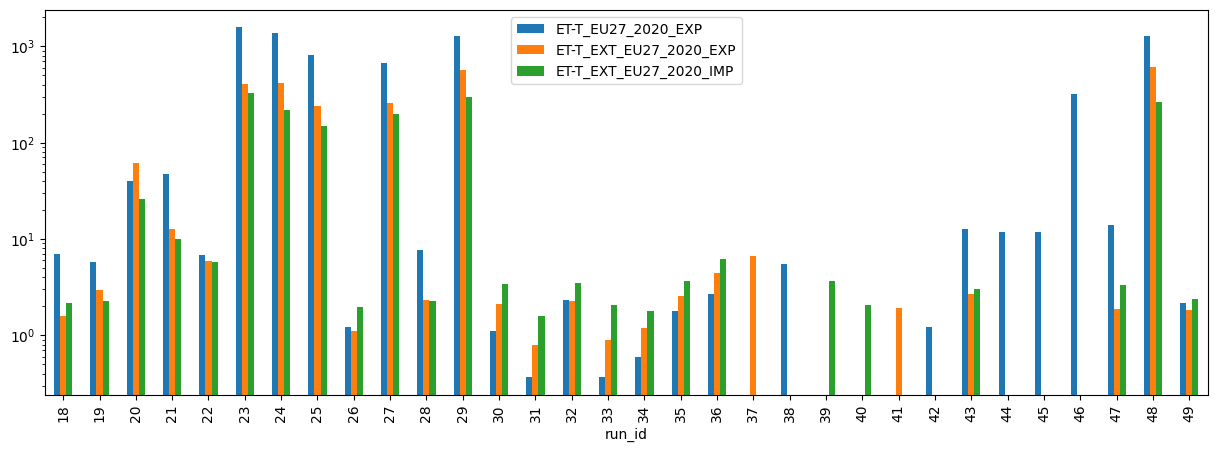

In [981]:
final_msre_raw = get_final_rmse(new_big_df, 'msre_raw')
print(final_msre_raw.where(final_msre_raw > 0, np.nan).idxmin())
final_msre_raw.plot.bar(logy=True, figsize=(15,5))

In [1002]:
print_comment([31,34,35,36,49])

31: base_data, 36 mo, default params, but with log transforms before
34: base_data + "ET-CONXT" + new future, 36 mo, default params, LOG TRANSFORMS
35: base_data + "ET-CONXT" + BU/shorterm, 36 mo, default params, LOG TRANSFORMS
36: base_data + BU/shorterm, 36 mo, light params, LOG TRANSFORMS
49: base data + moy + bu/shorterm, 36 mo, light params, 10 pred steps


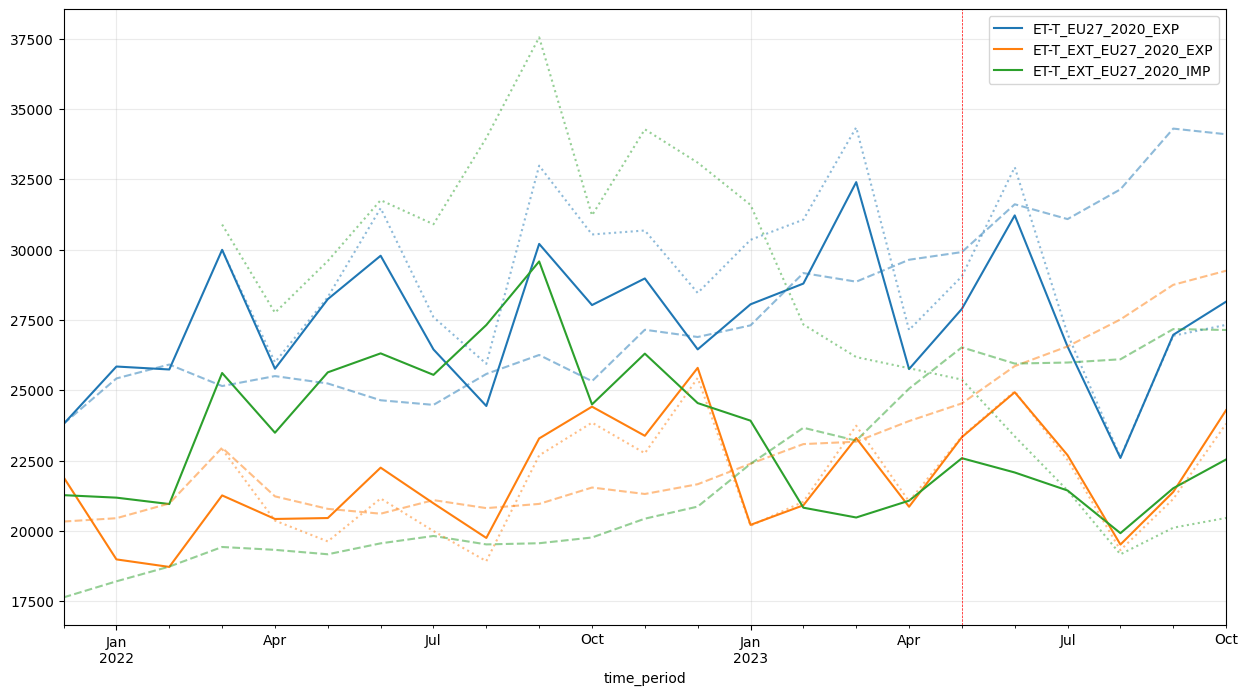

In [1021]:
run_id = 35
c = 'FR'
df_country = new_big_df.loc[run_id].loc[c].droplevel(0)
fig, ax = plt.subplots(figsize=(15,8))

for i, col in enumerate(['target', 'pred', 'adj_pred']):
    if i == 0:
        alpha, linestyle, legend = 1.0, '-', True
    elif i == 1:
        alpha, linestyle, legend = 0.5, '--', False
    else:
        alpha, linestyle, legend = 0.5, ':', False
    df_country[col].plot(ax=ax, alpha=alpha, linestyle=linestyle, legend=legend)
    ax.set_prop_cycle(None)
ax.grid(alpha=.25)
ax.axvline(df_country.index[-6], color='r', linestyle='--', linewidth=.5)



In [ ]:
time_horizon = 3
n_months = 6


df_samples_temp = df_samples[df_samples['time_horizon'] == time_horizon]
df_samples_temp[my_cols] = df_samples_temp[my_cols].where(df_samples_temp[my_cols] > 0, 50)

preds = df_samples_temp.groupby(['geo', 'time_period'])[my_cols].median()
preds = preds.where(preds > 0, 0)

target = df_target[my_cols]
target = target.loc[preds.index]

diff = preds - target
diff_pct = diff / target
rel_diff = preds / target
msre_raw = (diff_pct) ** 2


for country in diff.index.get_level_values(0).unique():
    print(country)
    figg, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))

    # plot preds and targets    
    target.loc[country].plot(ax=ax0, legend=False, title='Observed / Predicted')
    ax0.set_prop_cycle(None)
    preds.loc[country].plot(ax=ax0, legend=False, linestyle='--')

    # plot diff
    rel_diff.loc[country].plot(ax=ax1, title='Relative Diff')
    ax1.axhline(1, color='black', linestyle='--', linewidth=.25)
    ax1.set_ylim(0, 2)
    # ax1.axvline(1, color='black', linestyle='--', linewidth=.25)


    # plot msre
    msre_raw.loc[country].plot(ax=ax2, legend=False, title='MSRE')

    for ax in [ax0, ax1, ax2]:
        ax.axvline(diff.loc[country].index[-n_months], color='r', linestyle='--', linewidth=.5)
        ax.grid(alpha=.25)   
    plt.show()

### raw input df

<Axes: xlabel='time_period'>

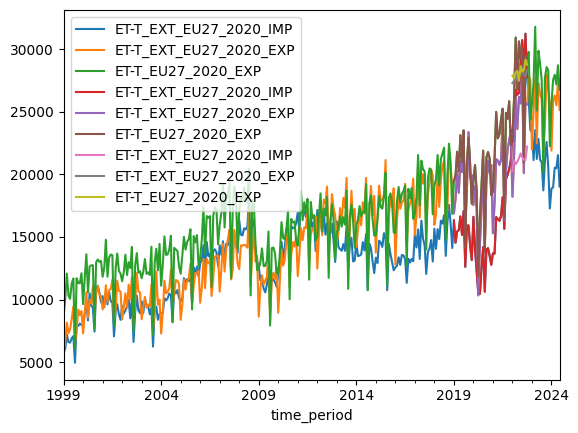

In [651]:
c = 'IT'
preds = sample_dict[(c, pd.Timestamp('2019-01-01 00:00:00'))]['preds'].cpu().numpy()
targets= sample_dict[(c, pd.Timestamp('2019-01-01 00:00:00'))]['targets'].cpu().numpy()
preds.shape, targets.shape


def make_analytics_df(targets, preds, start_time, my_cols):
    preds = pd.DataFrame(preds, columns=df.columns)
    preds.index = pd.date_range(start_time, periods=preds.shape[0], freq='MS')
    preds.index += pd.DateOffset(months=36)

    targets = pd.DataFrame(targets, columns=df.columns)
    targets.index = pd.date_range(start_time, periods=targets.shape[0], freq='MS')

    df = pd.concat([targets[my_cols], preds[my_cols]], keys=['target','pred'], axis=1)
    df['time_horizon'] = df['pred'].notna().any(axis=1).cumsum()

    return df
my_cols = [col for col in df.columns if col in TARGET_COLS]
ax = df.loc[c][my_cols].plot()
targets[my_cols].plot(ax=ax)
preds[my_cols].plot(ax=ax)

In [652]:
yo = pd.concat([targets[my_cols], preds[my_cols]], keys=['target','pred'], axis=1)
yo['time_horizon'] = yo['pred'].notna().any(axis=1).cumsum()
yo

target                                            \
           ET-T_EXT_EU27_2020_IMP ET-T_EXT_EU27_2020_EXP ET-T_EU27_2020_EXP   
2019-01-01           16323.500000           16888.400391       19430.800781   
2019-02-01           14537.099609           17995.699219       19903.199219   
2019-03-01           15436.999023           20228.199219       21801.398438   
2019-04-01           15535.898438           18525.099609       20257.099609   
2019-05-01           16633.400391           21021.599609       23128.199219   
2019-06-01           15164.000000           20179.599609       20968.199219   
2019-07-01           17077.798828           22641.201172       23510.902344   
2019-08-01           12611.399414           15686.699219       14121.700195   
2019-09-01           15904.700195           18714.099609       20969.000000   
2019-10-01           15916.500000           23367.601562       22942.800781   
2019-11-01           14278.500000           19710.199219       20764.300781   
2019-12-01           13145.999023           19946.500000       17649.599609   
2020-01-01           16605.000000           17541.199219       19460.699219   
2020-02-01           14013.099609           19050.000000       20732.599609   
2020-03-01           12263.299805           17208.298828       18667.898438   
2020-04-01           10488.099609           10329.799805       11861.199219   
2020-05-01           10448.399414           14441.701172       16579.199219   
2020-06-01           12557.299805           17183.099609       19073.199219   
2020-07-01           14184.099609           20798.201172       21894.601562   
2020-08-01           10629.699219           14171.800781       13801.799805   
2020-09-01           14005.499023           19260.500000       21340.199219   
2020-10-01           14099.899414           21095.800781       21780.500000   
2020-11-01           13474.099609           20099.699219       21263.800781   
2020-12-01           12773.099609           20744.800781       18337.101562   
2021-01-01           13692.499023           15286.599609       18633.000000   
2021-02-01           13656.199219           17665.898438       21227.500000   
2021-03-01           16578.900391           21199.900391       24984.300781   
2021-04-01           16437.000000           21111.701172       22870.800781   
2021-05-01           16285.500000           20753.701172       23200.300781   
2021-06-01           16675.701172           21161.500000       24385.898438   
2021-07-01           18173.701172           24371.400391       25237.500000   
2021-08-01           15645.199219           16363.599609       16533.800781   
2021-09-01           19589.199219           20230.800781       24912.101562   
2021-10-01           19973.599609           21935.400391       24433.101562   
2021-11-01           20404.000000           22755.500000       25840.800781   
2021-12-01           21109.400391           23333.201172       22342.699219   
2022-01-01           23564.300781           18207.699219       23009.300781   
2022-02-01           22628.199219           21393.400391       26021.800781   
2022-03-01           26751.500000           25898.900391       30918.500000   
2022-04-01           26360.000000           23614.000000       26773.699219   
2022-05-01           26501.900391           26190.400391       30615.199219   
2022-06-01           28714.699219           25664.500000       29216.199219   
2022-07-01           30719.400391           27964.699219       30068.500000   
2022-08-01           27790.798828           20097.599609       20955.199219   
2022-09-01           31230.900391           25704.201172       29468.597656   
2022-10-01           27750.400391           25578.099609       29258.898438   

                             pred                                            \
           ET-T_EXT_EU27_2020_IMP ET-T_EXT_EU27_2020_EXP ET-T_EU27_2020_EXP   
2019-01-01                    NaN                    NaN                NaN 

In [625]:
yo = pd.DataFrame({
    'targets': targets['ET-T_EU27_2020_EXP']
    'preds_at_9': preds['ET-T_EU27_2020_EXP'],
})

for horizon in range(preds.shape[0]):
    yo[f'pred_at_{horizon}'] = preds['ET-T_EU27_2020_EXP'].shift(-horizon)

yo

ValueError: Cannot set a DataFrame with multiple columns to the single column pred_at_1

In [541]:
# 'time_period' of df_indices has the "start_date" of each input MTS
df_indices = df_indices[df_indices['split']=='test']['time_period']
df_indices

3699   2018-03-01
3700   2018-04-01
3701   2018-05-01
3702   2018-06-01
3703   2018-07-01
          ...    
4501   2020-04-01
4502   2020-05-01
4503   2020-06-01
4504   2020-07-01
4505   2020-08-01
Name: time_period, Length: 807, dtype: datetime64[ns]

In [526]:
all_generated_samples.shape

torch.Size([807, 100, 46, 6])

torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])
torch.Size([100, 46, 6])


In [493]:
df_samples

ET-T_EU27_2020_EXP  ET-T_EXT_EU27_2020_EXP  ET-T_EXT_EU27_2020_IMP  \
0              8155.155273             3984.208496             3602.498779   
1              8560.662109             4795.887695             4553.270020   
2              9528.205078             4153.029297             3215.796875   
3             12973.507812             5515.362305             3652.894775   
4             10033.164062             7163.318359             3968.907227   
...                    ...                     ...                     ...   
121045         7581.733398             2133.708496             2100.375488   
121046         8211.662109             1969.010986             2323.514160   
121047         7035.574707             2197.141113             2356.927490   
121048         6342.375977             2252.701172             2353.351562   
121049         6298.548828             2452.557617             2934.919434   

        pred_id geo base_period  time_horizon time_period  
0             0  AT  2021-03-01             1  2021-04-01  
1             0  AT  2021-03-01             2  2021-05-01  
2             0  AT  2021-03-01             3  2021-06-01  
3             1  AT  2021-03-01             1  2021-04-01  
4             1  AT  2021-03-01             2  2021-05-01  
...         ...  ..         ...           ...         ...  
121045       48  SK  2023-08-01             2  2023-10-01  
121046       48  SK  2023-08-01             3  2023-11-01  
121047       49  SK  2023-08-01             1  2023-09-01  
121048       49  SK  2023-08-01             2  2023-10-01  
121049       49  SK  2023-08-01             3  2023-11-01  

[121050 rows x 8 columns]

# generate model predictions

In [210]:
run_id = 45

for run_id in range(18,47):
    path = f'../save/Forecasting/euro_all_countries/n_samples_100_run_{run_id}_linear_False_sample_feat_True'
    try:
        with open(f'{path}/generated_outputs_nsample100.pk', 'rb') as f:
            outputs = pickle.load(f)
            all_generated_samples, all_target, all_evalpoint, all_observed_point, all_observed_time, scaler, mean_scaler = outputs
        print(run_id, all_generated_samples.shape)
    except:
        print(run_id, 'no file')

18 torch.Size([807, 100, 39, 16])
19 torch.Size([807, 100, 39, 16])
20 torch.Size([807, 100, 39, 23])
21 torch.Size([807, 100, 39, 20])
22 torch.Size([807, 100, 39, 20])
23 torch.Size([807, 100, 39, 16])
24 torch.Size([807, 100, 39, 16])
25 torch.Size([807, 100, 39, 23])
26 torch.Size([807, 100, 39, 17])
27 torch.Size([807, 100, 39, 17])
28 torch.Size([807, 100, 39, 17])
29 torch.Size([807, 100, 39, 17])
30 torch.Size([807, 100, 39, 17])
31 torch.Size([807, 100, 46, 16])
32 torch.Size([807, 100, 46, 20])
33 torch.Size([807, 100, 46, 20])
34 torch.Size([807, 100, 46, 26])
35 torch.Size([807, 100, 46, 22])
36 torch.Size([807, 100, 46, 22])
37 torch.Size([807, 100, 46, 6])
38 torch.Size([807, 100, 46, 6])
39 torch.Size([807, 100, 46, 6])
40 torch.Size([807, 100, 46, 6])
41 torch.Size([807, 100, 46, 6])
42 torch.Size([807, 100, 46, 6])
43 torch.Size([807, 100, 46, 18])
44 torch.Size([807, 100, 46, 7])
45 torch.Size([807, 100, 46, 7])
46 torch.Size([807, 100, 39, 7])


In [196]:
all_generated_samples.shape

torch.Size([807, 100, 46, 7])

In [197]:
all_observed_point.shape

torch.Size([807, 46, 7])

In [ ]:
with torch.no_grad():
    model.eval()
    model()

In [1026]:
x = np.random.rand(5,5).round(2)
x

np.pad(x, ((0,0), (0,2)), mode='constant', constant_values=0)

array([[0.14, 0.54, 0.7 , 0.83, 0.62, 0.  , 0.  ],
       [0.33, 0.12, 0.25, 0.05, 0.82, 0.  , 0.  ],
       [0.49, 0.36, 0.56, 0.72, 0.22, 0.  , 0.  ],
       [0.42, 0.9 , 0.49, 0.03, 0.05, 0.  , 0.  ],
       [0.04, 0.82, 0.87, 0.67, 0.25, 0.  , 0.  ]])